# Social graphs project: Taylor swift network and analysis

Students:
- Raquel Chaves Martinez (s243297)
- Paula Gambus i Moreno
- Alessia Saccardo

In this notebook we will build and analyze a Taylor Swift song Network. This file will be structured as follows:
- [Data obtention and analysis](#data)



#### Load necessary packages

In [9]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from nltk.corpus import stopwords
# import nltk
import networkx as nx
import sys
import matplotlib.pyplot as plt
import pickle
# import community.community_louvain as community_louvain
from collections import defaultdict
import matplotlib.cm as cm
# from nltk.stem import WordNetLemmatizer
# import contractions 
# from wordcloud import WordCloud
from collections import Counter
import os 
import string
import textwrap
import seaborn as sns
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
# from nltk.corpus import wordnet
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

/Users/paulagambus/Documents/DTU/Fall_2024/social_graphs/sg_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id='data'></a>
## Data obtention and analysis

### Taylor Swift dataset Analysis

In [10]:
data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data = data.copy() # Remove dots in spotify streams

In [11]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [12]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [13]:
#print the number of albums and their names
print('Number of albums:', ts_data['album'].nunique())

Number of albums: 29


In [14]:
# change the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

We know that there are duplicates, let's print for each song the number of times it appears and the total number of songs repeated twice or three times.

In [17]:
print(ts_data['track_name'].value_counts(), '\n')

# check which songs are repeated and how many times
repeated_songs = ts_data['track_name'].value_counts()
repeated_songs_2 = repeated_songs[repeated_songs == 2]
repeated_songs_3 = repeated_songs[repeated_songs == 3]

print('This number of songs were repeated:', len(repeated_songs_2) + len(repeated_songs_3))
print('This number of songs were released twice:', len(repeated_songs_2))
print('This number of songs werec released three times:', len(repeated_songs_3))

track_name
illicit affairs                         3
Holy Ground                             3
mad woman                               3
epiphany                                3
betty                                   3
                                       ..
I Forgot That You Existed               1
Cruel Summer                            1
Lover                                   1
The Man                                 1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64 

This number of songs were repeated: 156
This number of songs were released twice: 96
This number of songs werec released three times: 60


Here we define a function to merge the rows that have the same exact track name

In [18]:
def merge_rows_with_same_name(df, key_column='track_name'):
    # Group by the key_column
    grouped = df.groupby(key_column)

    def merge_values(series):
        unique_values = series.dropna().unique()
        if len(unique_values) == 1:
            return unique_values[0]
        else:
            return list(unique_values)

    merged_df = grouped.agg({col: merge_values for col in df.columns if col != key_column}).reset_index()
    
    return merged_df

In [19]:
ts_data = merge_rows_with_same_name(ts_data)

In [20]:
print(ts_data['track_name'].value_counts())
print(ts_data.shape)

track_name
"Slut!" (Taylor's Version) (From The Vault)          1
The Bolter                                           1
The Best Day (Taylor's Version)                      1
The Best Day                                         1
The Archer                                           1
                                                    ..
I Forgot That You Existed                            1
I Don't Wanna Live Forever (Fifty Shades Darker)     1
I Did Something Bad                                  1
I Can See You (Taylor's Version) (From The Vault)    1
willow                                               1
Name: count, Length: 361, dtype: int64
(361, 27)


In [21]:
# Flatten the 'album' column if it contains lists
flattened_albums = ts_data['album'].explode()  # Explodes lists into separate rows
unique_albums = flattened_albums.dropna().unique()
print(unique_albums)

["1989 (Taylor's Version) [Deluxe]" "1989 (Taylor's Version)" 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' 'Red (Deluxe Edition)'
 'Red' "Red (Taylor's Version)" 'Taylor Swift' 'Lover'
 '1989 (Deluxe Edition)' '1989' 'Midnights (The Til Dawn Edition)'
 'Midnights (3am Edition)' 'Midnights' 'Speak Now (Deluxe Edition)'
 'Speak Now' "Speak Now (Taylor's Version)" 'Speak Now World Tour Live'
 'Live From Clear Channel Stripped 2008' 'Fearless Platinum Edition'
 'Fearless' "Fearless (Taylor's Version)"
 'The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'evermore (deluxe version)'
 'evermore']


In [22]:
# Remove æive album because we don't have critics on it and some songs don't have lyrics
ts_data = ts_data[ts_data['album'] != 'Speak Now World Tour Live']

Firstly, we did some analysis to know how the dataset is and what could we investigate. We wanted to know more about the streams so we generated some plots.

In [34]:
data['spotify_streams']

ID
0      648525069
1      206954130
2      238016975
3      318375377
4      253712712
         ...    
572    328676348
573     49912790
574     34315147
575     25204096
576     32775607
Name: spotify_streams, Length: 577, dtype: object

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (577,) and arg 1 with shape (345,).

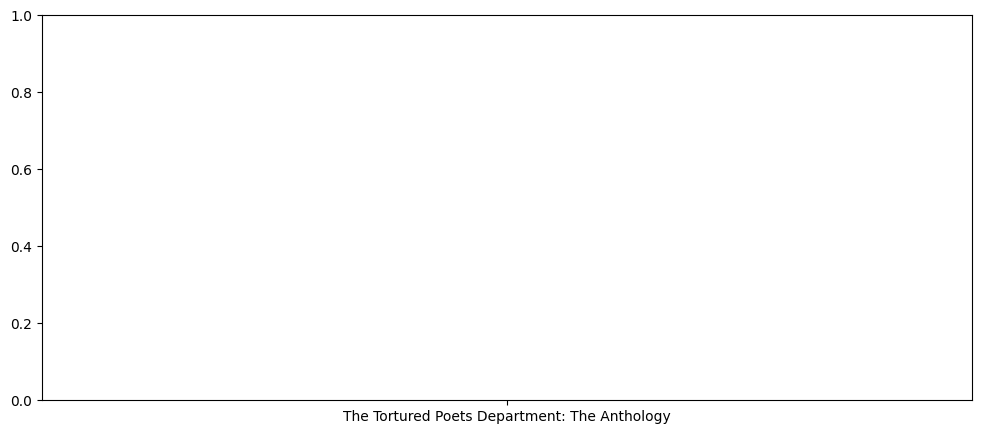

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(ts_data['album'], ts_data['spotify_streams'], color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.title('Number of streams per album')
plt.ylabel('Number of streams')
plt.xlabel('Album')
plt.tight_layout() 
plt.show()

In [ ]:
# average of streams per album
plt.figure(figsize=(12, 6))
ts_data.groupby('album')['spotify_streams'].mean().plot(kind='bar', color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Album')
plt.ylabel('Average of streams')
plt.title('Average of streams per album')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

In [ ]:
# average of streams per year taking into account how many songs were released that year
plt.figure(figsize=(12, 6))
ts_data.groupby(ts_data['release_date'].dt.year)['spotify_streams'].sum().plot(kind='bar', color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of streams')
plt.title('Number of streams per year')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

Moreover, we wanted to know the genres that Taylor Swift sings and how many songs per album she released.

In [ ]:
# how many genres and list them
print('Number of genres:', ts_data['track_musical_genre'].nunique())
print(ts_data['track_musical_genre'].unique())

# number of songs per genre plot
plt.figure(figsize=(12, 6))
plt.bar(ts_data['track_musical_genre'].value_counts().index, ts_data['track_musical_genre'].value_counts().values, color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of songs')
plt.title('Number of songs per genre')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()


In [ ]:
# number of songs per album
plt.figure(figsize=(12, 6))
plt.bar(ts_data['album'].value_counts().index, ts_data['album'].value_counts().values, color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Album')
plt.ylabel('Number of songs')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

Finally 

### Web scrapping of Metacritic

With the aim of enlarging our Taylor Swift discography analysis, we decided to analyze the review of her albums. To do so, we did web scraping of the Metacritic web page.

First we need to get the links to the pages that will allow us to scrape the desired information.

In [63]:
links = [
'https://www.metacritic.com/music/taylor-swift/taylor-swift',
'https://www.metacritic.com/music/1989/taylor-swift', 
'https://www.metacritic.com/music/fearless/taylor-swift', 
'https://www.metacritic.com/music/speak-now/taylor-swift', 
'https://www.metacritic.com/music/red/taylor-swift', 
'https://www.metacritic.com/music/reputation/taylor-swift', 
'https://www.metacritic.com/music/lover/taylor-swift',
'https://www.metacritic.com/music/folklore/taylor-swift',
'https://www.metacritic.com/music/evermore/taylor-swift',
'https://www.metacritic.com/music/fearless-taylors-version/taylor-swift',
'https://www.metacritic.com/music/red-taylors-version/taylor-swift',
'https://www.metacritic.com/music/midnights/taylor-swift',
'https://www.metacritic.com/music/speak-now-taylors-version/taylor-swift',
'https://www.metacritic.com/music/1989-taylors-version/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department-the-anthology/taylor-swift']

We then built a function that returns the source, score and summary of each review.

In [64]:
def scrape_metacritic_reviews(url, n_critics):
    """
    Function that extracts the critic reviews from a Metacritic page.
    url: str, the URL of the Metacritic page of the album reviews
    n_critics: int, the number of critics to extract
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all sources
    critic_sources = []
    source_div = soup.find_all("div", class_="source")
    for source in source_div:
        source_name = source.find("a").text.strip() if source.find("a") else "Source Not Found"
        #print(source_name)
        critic_sources.append(str(source_name))
    
    # Extract all critic scores
    critic_scores = []
    review_grade_divs = soup.find_all("div", class_="review_grade")
    for review_grade in review_grade_divs:
        score = review_grade.find("div", class_="metascore_w")
        if score:
            critic_scores.append(int(score.text.strip()))

    # Extract all review bodies
    review_bodies = []
    review_body_divs = soup.find_all("div", class_="review_body")
    for review_body in review_body_divs:
        body = review_body.text.strip() if review_body else "No Review Body"
        review_bodies.append(str(body))

    
    # only keep the information of the first n_critics (those corresponding to the critics' reviews)
    critic_scores = critic_scores[:n_critics]
    review_bodies = review_bodies[:n_critics]
    # make a new list of tuples (critic_score, review_body)
    critic_reviews = list(zip(critic_sources, critic_scores, review_bodies))

    return critic_reviews

We also defined a function that takes the album url and extracts the link to the review pages. This function returns the album and the reviews.

In [65]:
# Function to scrape album data from Metacritic
def scrape_metacritic_album(url):
    """
    This function takes the album url and returns the album title, number of critics and reviews.
    url: str, the URL of the Metacritic page of the album
    """

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract album title
    title = soup.find("h1").text.strip() if soup.find("h1") else "Title Not Found"
    print(title)

    # Extract Metascore
    metascore = soup.find("span", itemprop="ratingValue").text.strip() if soup.find("span", class_="metascore_w") else "No Metascore"
    #print(metascore)
    
    n_critics = soup.find("span", itemprop="reviewCount").text.strip() if soup.find("span", itemprop="reviewCount") else "No Critic Count"
    n_critics = int(n_critics.split()[0])
    
    # Extract review link from metascore_anchor class
    review_link_tag = soup.find("a", class_="metascore_anchor")
    review_link = review_link_tag['href'] if review_link_tag and review_link_tag.has_attr('href') else None
    if review_link:
        review_link = f"https://www.metacritic.com{review_link}"
        #print(review_link)

    reviews = scrape_metacritic_reviews(review_link, n_critics)

    # Return the extracted data
    return {
        "title": title,
        "number of critics": n_critics,
        "reviews": reviews,
    }

The last function that we build related to the web scrapping is the one that allows us to save the data in .csv files.

In [66]:
def save_album_data_to_csv(data):
    """
    This function is used to save the album data to a CSV file.
    data: dict, a dictionary containing the album data
    """
    # Clean the album title for file naming
    title = data["title"].replace(" ", "_").replace("/", "_")

    # Create a DataFrame from the reviews
    df = pd.DataFrame(data["reviews"], columns=["source","score", "review"])

    # Define output directory and file path
    output_dir = "./data/album_reviews"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{title}.csv")

    # Save DataFrame to CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved data for album '{data['title']}' to {csv_path}")

Finally, we obtain the files with the reviews and save them.

In [67]:
for link in links:
    data = scrape_metacritic_album(link)
    save_album_data_to_csv(data)

Taylor Swift
Saved data for album 'Taylor Swift' to ./data/album_reviews/Taylor_Swift.csv
1989
Saved data for album '1989' to ./data/album_reviews/1989.csv
Fearless
Saved data for album 'Fearless' to ./data/album_reviews/Fearless.csv
Speak Now
Saved data for album 'Speak Now' to ./data/album_reviews/Speak_Now.csv
Red
Saved data for album 'Red' to ./data/album_reviews/Red.csv
reputation
Saved data for album 'reputation' to ./data/album_reviews/reputation.csv
Lover
Saved data for album 'Lover' to ./data/album_reviews/Lover.csv
folklore
Saved data for album 'folklore' to ./data/album_reviews/folklore.csv
evermore
Saved data for album 'evermore' to ./data/album_reviews/evermore.csv
Fearless (Taylor's Version)
Saved data for album 'Fearless (Taylor's Version)' to ./data/album_reviews/Fearless_(Taylor's_Version).csv
Red (Taylor's Version)
Saved data for album 'Red (Taylor's Version)' to ./data/album_reviews/Red_(Taylor's_Version).csv
Midnights
Saved data for album 'Midnights' to ./data/album

# Build the network

### Clean the lyrics

In [15]:
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text = contractions.fix(text)
    
    # Remove text enclosed in square brackets, like [Verse 1: Taylor Swift]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lemmatization (convert words to their root form)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text



In [16]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                                           22   
3                        22 (Taylor's Version)   
4                       A Perfectly Good Heart   

                                      cleaned_lyrics  
0  flamingo pink sunrise boulevard clink clink yo...  
1  knew killer first time saw wondered many girl ...  
2  feel like perfect night dress like hipster mak...  
3  feel like perfect night dress like hipster mak...  
4  would want break perfectly good heart would wa...

### Compute similarity between songs using tf-idf score and consine similarity

In [17]:
def compute_tfidf_similarity(data, text_column, index_column):
    """
    Compute TF-IDF scores and a similarity matrix for a dataset.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - text_column (str): The column containing text data for TF-IDF computation.
    - index_column (str): The column to use as the index for similarity and TF-IDF DataFrames.

    Returns:
    - tfidf_df (pd.DataFrame): DataFrame of TF-IDF scores.
    - similarity_df (pd.DataFrame): Pairwise similarity matrix based on cosine similarity.
    """
    # Step 1: Calculate TF-IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[text_column])

    # Step 2: Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 3: Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=data[index_column]
    )

    # Step 4: Compute the similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 5: Convert the similarity matrix to a DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data[index_column],
        columns=data[index_column]
    )

    # Return both TF-IDF and similarity DataFrames
    return tfidf_df, similarity_df

In [18]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

# Display a sample of the TF-IDF and similarity matrices
print("TF-IDF DataFrame:")
print(tfidf_df.shape)
tfidf_df.head()

TF-IDF DataFrame:
(345, 4303)


158  16th   17  1830s  1944  \
track_name                                                                 
"Slut!" (Taylor's Version) (From The Vault)  0.0   0.0  0.0    0.0   0.0   
...Ready For It?                             0.0   0.0  0.0    0.0   0.0   
22                                           0.0   0.0  0.0    0.0   0.0   
22 (Taylor's Version)                        0.0   0.0  0.0    0.0   0.0   
A Perfectly Good Heart                       0.0   0.0  0.0    0.0   0.0   

                                             1950s  1958  2003  230   25  ...  \
track_name                                                                ...   
"Slut!" (Taylor's Version) (From The Vault)    0.0   0.0   0.0  0.0  0.0  ...   
...Ready For It?                               0.0   0.0   0.0  0.0  0.0  ...   
22                                             0.0   0.0   0.0  0.0  0.0  ...   
22 (Taylor's Version)                          0.0   0.0   0.0  0.0  0.0  ...   
A Perfectly Good Heart                         0.0   0.0   0.0  0.0  0.0  ...   

                                                  you  youi     young  \
track_name                                                              
"Slut!" (Taylor's Version) (From The Vault)  0.022968   0.0  0.048119   
...Ready For It?                             0.048531   0.0  0.000000   
22                                           0.040954   0.0  0.000000   
22 (Taylor's Version)                        0.040954   0.0  0.000000   
A Perfectly Good Heart                       0.000000   0.0  0.000000   

                                              younger  youplease  your  yours  \
track_name                                                                      
"Slut!" (Taylor's Version) (From The Vault)  0.000000        0.0   0.0    0.0   
...Ready For It?                             0.052495        0.0   0.0    0.0   
22                                           0.000000        0.0   0.0    0.0   
22 (Taylor's Version)                        0.000000        0.0   0.0    0.0   
A Perfectly Good Heart                       0.000000        0.0   0.0    0.0   

                                             yourself  youth  zlister  
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)       0.0    0.0      0.0  
...Ready For It?                                  0.0    0.0      0.0  
22                                                0.0    0.0      0.0  
22 (Taylor's Version)                             0.0    0.0      0.0  
A Perfectly Good Heart                            0.0    0.0      0.0  

[5 rows x 4303 columns]

In [19]:
print("Similarity Matrix:")
print(similarity_df.shape)
similarity_df.head(10)

Similarity Matrix:
(345, 345)


track_name                                          "Slut!" (Taylor's Version) (From The Vault)  \
track_name                                                                                        
"Slut!" (Taylor's Version) (From The Vault)                                            1.000000   
...Ready For It?                                                                       0.039831   
22                                                                                     0.025628   
22 (Taylor's Version)                                                                  0.025628   
A Perfectly Good Heart                                                                 0.035435   
A Place in this World                                                                  0.039183   
Afterglow                                                                              0.084422   
All Too Well                                                                           0.121836   
All Too Well (10 Minute Version) (Taylor's Vers...                                     0.116570   
All Too Well (Taylor's Version)                                                        0.121836   

track_name                                          ...Ready For It?  \
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)                 0.039831   
...Ready For It?                                            1.000000   
22                                                          0.061747   
22 (Taylor's Version)                                       0.061747   
A Perfectly Good Heart                                      0.036758   
A Place in this World                                       0.078595   
Afterglow                                                   0.058289   
All Too Well                                                0.063346   
All Too Well (10 Minute Version) (Taylor's Vers...          0.044343   
All Too Well (Taylor's Version)                             0.063346   

track_name                                                22  \
track_name                                                     
"Slut!" (Taylor's Version) (From The Vault)         0.025628   
...Ready For It?                                    0.061747   
22                                                  1.000000   
22 (Taylor's Version)                               1.000000   
A Perfectly Good Heart                              0.025080   
A Place in this World                               0.083865   
Afterglow                                           0.087050   
All Too Well                                        0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...  0.054785   
All Too Well (Taylor's Version)                     0.078212   

track_name                                          22 (Taylor's Version)  \
track_name                                                                  
"Slut!" (Taylor's Version) (From The Vault)                      0.025628   
...Ready For It?                                                 0.061747   
22                                                               1.000000   
22 (Taylor's Version)                                            1.000000   
A Perfectly Good Heart                                           0.025080   
A Place in this World                                            0.083865   
Afterglow                                                        0.087050   
All Too Well                                                     0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...               0.054785   
All Too Well (Taylor's Version)                                  0.078212   

track_name                                          A Perfectly Good Heart  \
track_name                                                                   
"Slut!" (Taylor's Version) (From The Vault)                       0.035435   
...Ready For It?  

In [20]:
similarity_threshold = 0.97

# Initialize a set to store the pairs
high_similarity_pairs = set()

# Iterate through the similarity matrix
for song1 in similarity_df.index:
    for song2 in similarity_df.columns:
        # Exclude self-similarity and check if the score exceeds the threshold
        if song1 != song2 and similarity_df.at[song1, song2] > similarity_threshold:
            # Add the pair to the set (ensuring each pair is unique)
            pair = tuple(sorted((song1, song2)))
            high_similarity_pairs.add((pair[0], pair[1], similarity_df.at[song1, song2]))

# Convert the set to a DataFrame
high_similarity_df = pd.DataFrame(high_similarity_pairs, columns=["Song1", "Song2", "Similarity"])
print(high_similarity_df.shape)
high_similarity_df.head(50)


(133, 3)


Song1  \
0                                                 Red   
1                                                 Red   
2                                            Fearless   
3                      Blank Space (Taylor's Version)   
4   State Of Grace (Acoustic Version) (Taylor's Ve...   
5   State Of Grace (Acoustic Version) (Taylor's Ve...   
6                                           Starlight   
7                     the last great american dynasty   
8                                          Love Story   
9                                         Treacherous   
10                                          Enchanted   
11                                    You Are In Love   
12                                       Girl At Home   
13                                               Mine   
14                                  my tears ricochet   
15                                                 22   
16                          Change (Taylor's Version)   
17                                     State Of Grace   
18                                               Babe   
19                     Untouchable (Taylor's Version)   
20                                         mirrorball   
21        Teardrops On My Guitar - Radio Single Remix   
22  Forever & Always (Piano Version) (Taylor's Ver...   
23                         Haunted (Taylor's Version)   
24                                            Haunted   
25                             exile (feat. Bon Iver)   
26                                           Fearless   
27             Miss Americana & The Heartbreak Prince   
28                                     Jump Then Fall   
29                                           epiphany   
30                                   I Wish You Would   
31                                   Forever & Always   
32                               How You Get The Girl   
33                            the lakes - bonus track   
34                                              Clean   
35                                   Back To December   
36                                    Picture To Burn   
37                                        Blank Space   
38                              Come In With The Rain   
39                                Better Than Revenge   
40                     Treacherous (Taylor's Version)   
41                                   I Wish You Would   
42            We Are Never Ever Getting Back Together   
43                                  this is me trying   
44                                    illicit affairs   
45                                Welcome To New York   
46                                   Forever & Always   
47                                      Never Grow Up   
48                                   You're Not Sorry   
49                                          mad woman   

                                                Song2  Similarity  
0                       Red - Original Demo Recording         1.0  
1                              Red (Taylor's Version)         1.0  
2                         Fearless (Taylor's Version)         1.0  
3                            Blank Space - Voice Memo         1.0  
4                           State Of Grace - Acoustic         1.0  
5                   State Of Grace (Taylor's Version)         1.0  
6                        Starlight (Taylor's Version)         1.0  
7   the last great american dynasty - the long pon...         1.0  
8                       Love Story (Taylor's Version)         1.0  
9                      Treacherous (Taylor's Version)         1.0  
10                       Enchanted (Taylor's Version)         1.0  
11                 You Are In Love (Taylor's Version)         1.0  
12                    Girl At Home (Taylor's Version)         1.0  
13                                     Mine - POP Mix         1.0  
14  my tears ricochet - the long pond studio sessions         1.0  
15                              22 (Taylor's Version

In [21]:
def merge_rows(row1, row2, columns):
    """
    Merges two rows by comparing column values.
    If values differ, save as a list; otherwise, keep a single value.
    Handles cases where fields might already be lists.
    """
    merged_row = {}
    for col in columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)  # Extend if already a list
            else:
                values.append(value)  # Append single values
        
        # Ensure values are unique and check for pre-existing lists
        unique_values = pd.Series(values).dropna().unique()
        # If only one unique value exists, keep it; otherwise, store as a list
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    return merged_row

# Function to merge the dataset based on high similarity pairs
def merge_high_similarity_rows(dataset, high_similarity_df):
    # Copy the dataset to avoid modifying the original
    updated_dataset = dataset.copy()
    columns = dataset.columns.tolist()
    
    for _, (song1, song2, _) in high_similarity_df.iterrows():
        # Find the rows corresponding to the pair
        row1 = updated_dataset.loc[updated_dataset['track_name'] == song1]
        row2 = updated_dataset.loc[updated_dataset['track_name'] == song2]
        
        if not row1.empty and not row2.empty:
            row1 = row1.iloc[0]
            row2 = row2.iloc[0]
            
            # Determine the shortest track name
            shortest_name = song1 if len(song1) <= len(song2) else song2
            
            # Merge the two rows
            merged_row = merge_rows(row1, row2, columns)
            merged_row['track_name'] = shortest_name  # Set the shortest name as the track name
            
            # Remove the original rows
            updated_dataset = updated_dataset[~updated_dataset['track_name'].isin([song1, song2])]
            
            # Add the merged row
            updated_dataset = pd.concat([updated_dataset, pd.DataFrame([merged_row])], ignore_index=True)
    
    return updated_dataset

# Apply the merging function to the dataset
updated_ts_data = merge_high_similarity_rows(ts_data, high_similarity_df)



In [22]:
updated_ts_data

track_name  \
0    "Slut!" (Taylor's Version) (From The Vault)   
1                               ...Ready For It?   
2                         A Perfectly Good Heart   
3                          A Place in this World   
4                                      Afterglow   
..                                           ...   
230                                The Lucky One   
231         Teardrops on My Guitar - Pop Version   
232                                The Last Time   
233                           You Belong With Me   
234                                     Innocent   

                   track_musical_genre                     track_type  \
0                            Synth Pop                         Single   
1                           Electropop                         Single   
2                          Country Pop                         B-Side   
3                          Country Pop                         B-Side   
4                                  Pop                         B-Side   
..                                 ...                            ...   
230                           Pop Rock                         B-Side   
231  [Country  , Country, Country Pop]  [Live, Single, Remix, B-Side]   
232                   Alternative Rock               [Single, B-Side]   
233                        Country Pop               [Single, B-Side]   
234                           Pop Rock                         B-Side   

                          duration_ms               feature track_videoclip  \
0                              180381                    No              No   
1                              208186                    No             Yes   
2                              220146                    No              No   
3                    [202080, 199200]                    No              No   
4                              223293                    No              No   
..                                ...                   ...             ...   
230          [240266, 240133, 240466]                    No              No   
231  [196346, 204706, 203040, 179066]                    No       [No, Yes]   
232                  [298293, 299080]  [No, Gary Lightbody]              No   
233          [231146, 231133, 231124]                    No       [No, Yes]   
234                  [302253, 301221]                    No              No   

        videoclip_views                spotify_streams spotify_global_peak  \
0                     0                      239579759                   2   
1           350.707.005                      695895392                   3   
2                     0                       25204096                   0   
3                     0                       40680546                   0   
4                     0                      368409481                  38   
..                  ...                            ...                 ...   
230                   0           [43654609, 74802137]             [0, 41]   
231    [0, 170.366.264]  [746505, 210533930, 32775607]                   0   
232                   0          [66262839, 108741392]             [0, 29]   
233  [0, 1.580.778.473]         [628076118, 619978693]             [0, 16]   
234                   0           [51675352, 44117403]             [0, 23]   

                                                 album  ...  \
0    [1989 (Taylor's Version) [Deluxe], 1989 (Taylo...  ...   
1                                           reputation  ...   
2                                         Taylor Swift  ...   
3    [reputation Stadium Tour Surprise Song Playlis...  ...   
4                                                Lover  ...   
..                                                 ...  ...   
230  [reputation Stadium Tour Surprise Song Playlis...  ...   
231  [Live From Clear Channel Stripped 2008, reputa...  ...   
232  [Red (Deluxe Edition), Red, Red (Taylor's Vers...  ...   
233  [Fearless Plati

In [23]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=updated_ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

### Extract top 10 words per song 

In [24]:
def extract_top_words(tfidf_df, top_n=10):
    """
    Extracts the top N highest-scoring words for each song from the TF-IDF DataFrame.

    Parameters:
        tfidf_df (DataFrame): The TF-IDF DataFrame with songs as rows and words as columns.
        top_n (int): The number of top words to extract for each song.

    Returns:
        DataFrame: A DataFrame with 'track_name' and 'top_words' columns.
    """
    top_words = []

    # Iterate over each song in the TF-IDF DataFrame
    for track_name, row in tfidf_df.iterrows():
        # Get the top N words with the highest TF-IDF scores
        top_word_indices = row.nlargest(top_n).index
        top_word_scores = row.nlargest(top_n).values
        words_with_scores = [(word, score) for word, score in zip(top_word_indices, top_word_scores)]
        
        # Append the song and its top words to the list
        top_words.append({
            'track_name': track_name,
            'top_words': words_with_scores
        })

    # Convert the list to a DataFrame
    top_words_df = pd.DataFrame(top_words)
    return top_words_df

# Extract top 10 words for each song
top_words_df = extract_top_words(tfidf_df, top_n=20)

# Display the resulting DataFrame
top_words_df.head()


track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                       A Perfectly Good Heart   
3                        A Place in this World   
4                                    Afterglow   

                                           top_words  
0  [(might, 0.3569688448161781), (slut, 0.3053722...  
1  [(begin, 0.5379038688265549), (game, 0.3842918...  
2  [(perfectly, 0.42725262582385404), (want, 0.40...  
3  [(oh, 0.41883244597634794), (own, 0.3845367444...  
4  [(want, 0.3663974890957303), (lose, 0.32328300...

1733340 1993770030


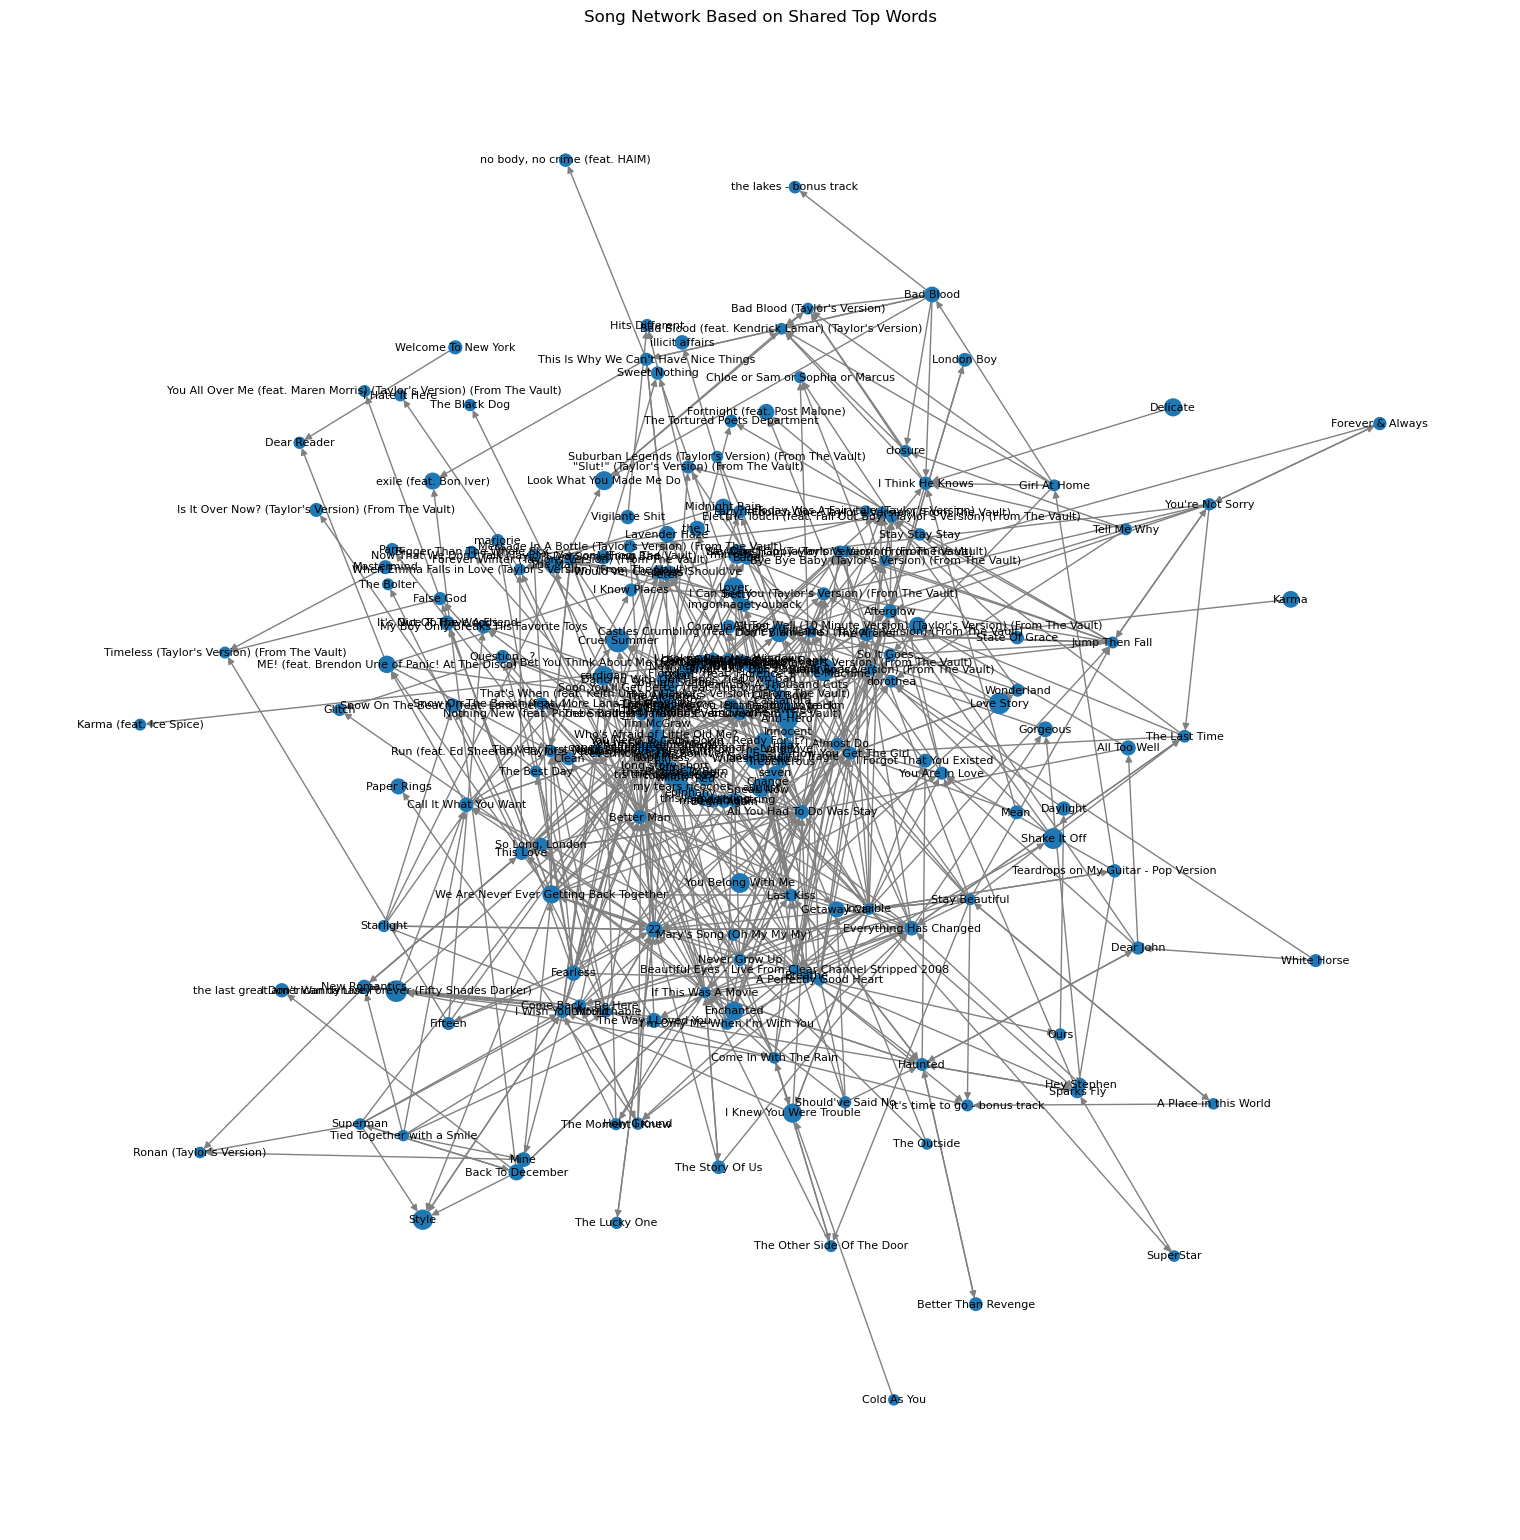

Number of nodes: 235
Number of edges: 496


In [25]:
import networkx as nx

def build_song_network(ts_data, top_words_df, min_shared_words=1):
    """
    Builds a directed song network based on shared top words and release dates.

    Parameters:
        ts_data (DataFrame): The original dataset with song metadata, including release dates.
        top_words_df (DataFrame): DataFrame containing track names and their top words.
        min_shared_words (int): Minimum number of shared words required to create an edge.

    Returns:
        nx.DiGraph: A directed network of songs.
    """
    G = nx.DiGraph()

    # Build a mapping of song to top words
    song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

    # Add nodes to the graph
    for _, row in ts_data.iterrows():
        G.add_node(
            row['track_name'], 
            release_date=row['release_date'],
            genre=row['track_musical_genre'], 
            spotify_streams=row['spotify_streams'],
            album = row['album']
        )

    # Add edges based on shared words and release dates
    for song1, words1 in song_to_words.items():
        for song2, words2 in song_to_words.items():
            if song1 != song2:
                # Find common words between the two songs
                common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
                if len(common_words) >= min_shared_words:
                    # Determine the direction of the edge based on release date
                    date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
                    date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

                    # Handle lists in release_date
                    if isinstance(date1, list):
                        date1 = min(date1)
                    if isinstance(date2, list):
                        date2 = min(date2)

                    # Add edge based on release date comparison
                    if date1 < date2:
                        G.add_edge(song1, song2, weight=len(common_words))
                    else:
                        G.add_edge(song2, song1, weight=len(common_words))

    return G

# Build the song network
net = build_song_network(updated_ts_data, top_words_df, min_shared_words=3)

node_sizes = []
for node in net.nodes:
    streams = net.nodes[node]['spotify_streams']
    if isinstance(streams, list):
        # If spotify_streams is a list, sum the values
        node_sizes.append(sum(streams))
    else:
        # If it's a single value, just append it
        node_sizes.append(streams)

# Normalize the node sizes to make them visually appropriate
max_streams = max(node_sizes)
min_streams = min(node_sizes)
print(min_streams, max_streams)
normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]



plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(net)  
nx.draw(
    net, pos, with_labels=True, 
    node_size=normalized_sizes, font_size=8, edge_color="gray", arrowsize=10
)
plt.title("Song Network Based on Shared Top Words")
plt.show()

# Display network statistics
print(f"Number of nodes: {net.number_of_nodes()}")
print(f"Number of edges: {net.number_of_edges()}")


In [26]:
# Save the network 
with open('song_network.pkl', 'wb') as f:
    pickle.dump(net, f)

In [27]:
updated_ts_data.to_pickle("ts_data.pkl")
print("DataFrame saved as 'updated_ts_data.pkl'")

DataFrame saved as 'updated_ts_data.pkl'


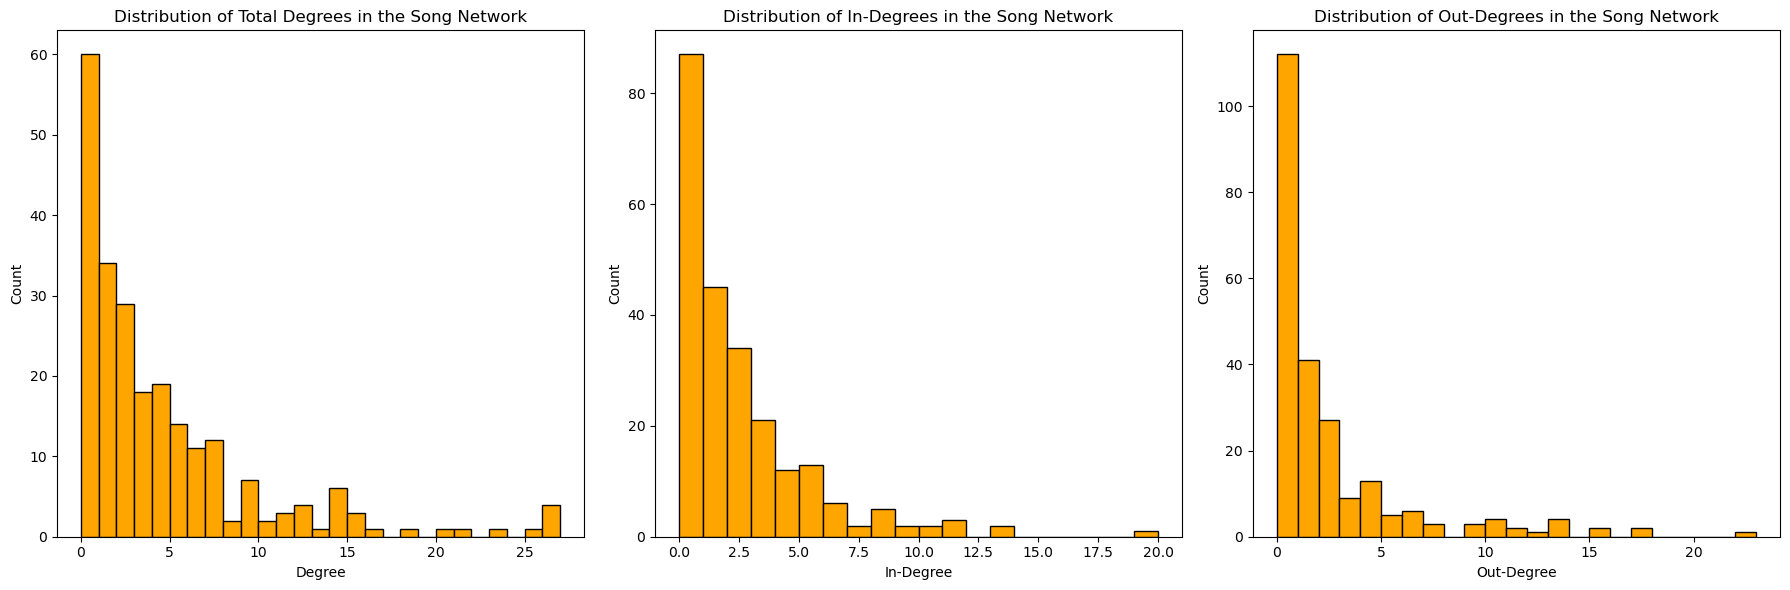

In [28]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in net.degree()]
in_degrees = [d for n, d in net.in_degree()]
out_degrees = [d for n, d in net.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [29]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(net.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(net.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+------------------------------------------------------------+-------------+
| Song                                                       |   In-Degree |
+============================================================+=============+
| The Very First Night (Taylor's Version) (From The Vault)   |          20 |
+------------------------------------------------------------+-------------+
| Don't You (Taylor's Version) (From The Vault)              |          13 |
+------------------------------------------------------------+-------------+
| Better Man                                                 |          13 |
+------------------------------------------------------------+-------------+
| Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault) |          11 |
+------------------------------------------------------------+-------------+
| 22                                                         |          11 |
+---------------------

# Communities

In [30]:
# Make graph undirected
undirected_net = net.to_undirected()

In [31]:
# Extract the Giant Connected Component (GCC)
largest_cc = max(nx.connected_components(undirected_net), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")

GCC has 173 nodes and 464 edges


In [32]:
# Detect communities in the GCC
# partition = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition.pkl", "wb") as f:
#     pickle.dump(partition, f)

# Load partitions
with open("partition.pkl", "rb") as f:
    partition = pickle.load(f)

# Compute modularity for the GCC
modularity = community_louvain.modularity(partition, gcc)
print(f"Number of communities in GCC: {len(set(partition.values()))}")
print(f"Modularity value for GCC: {modularity}")

Number of communities in GCC: 9
Modularity value for GCC: 0.4877700531340194


In [33]:
# Group nodes by community and name them after the song with highest degree

communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
print(community_names)


Communities named by highest-degree song:
{0: 'Invisible', 1: 'Afterglow', 2: 'Stay Beautiful', 3: 'All You Had To Do Was Stay', 4: 'I Think He Knows', 5: 'Better Man', 6: "The Very First Night (Taylor's Version) (From The Vault)", 7: 'Untouchable', 8: 'If This Was A Movie'}


/home/alesac/miniconda/envs/social_graph/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


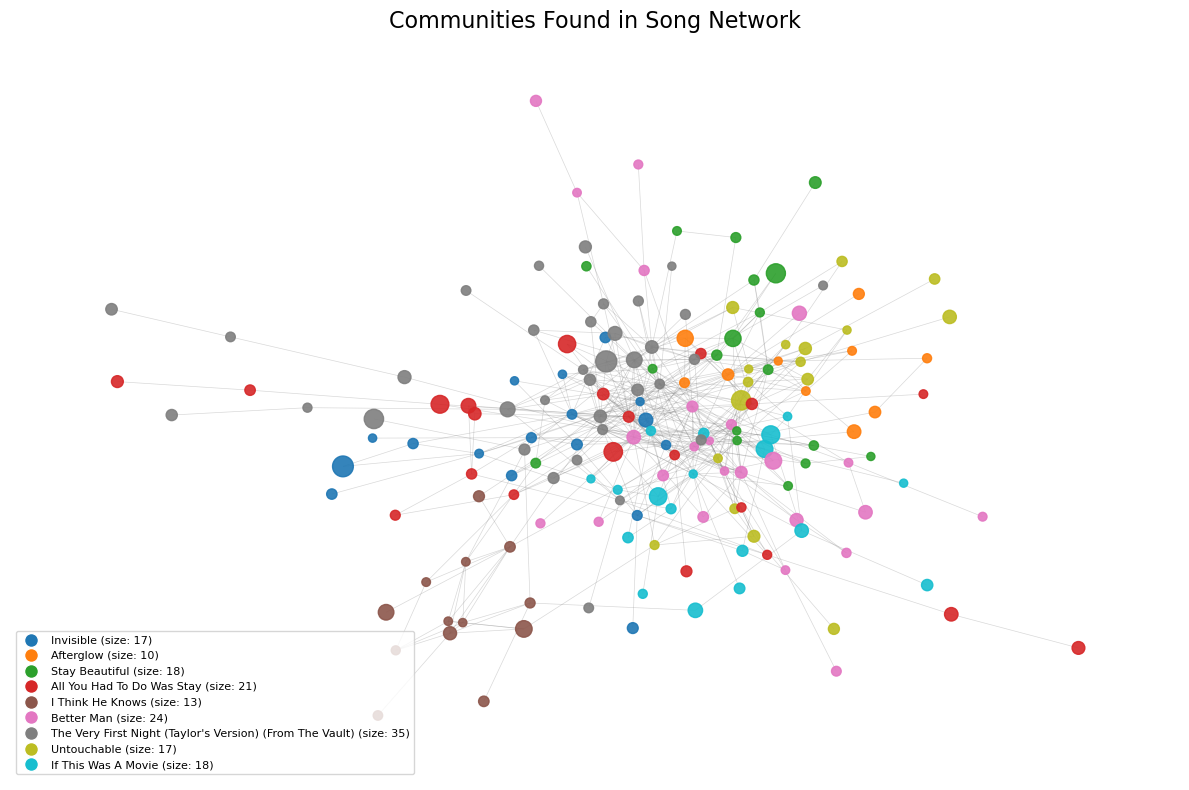

In [34]:
# Prepare a color map for communities
num_communities = len(communities)
colors = plt.get_cmap("tab10", num_communities)

# Assign a color to each node based on its community
node_colors = [colors(partition[node]) for node in gcc.nodes()]

# Assign node sizes based on Spotify streams (or degree if not available)
node_sizes = [
    30 + (sum(gcc.nodes[node].get("spotify_streams", [1])) / 1e7) 
    if isinstance(gcc.nodes[node].get("spotify_streams"), list)
    else 30 + (gcc.nodes[node].get("spotify_streams", 1) / 1e7) 
    for node in gcc.nodes()
]

# Compute layout
pos = nx.spring_layout(gcc, seed=42)  # Force-directed layout with a fixed seed for consistency

# Plot the graph
plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(
    gcc,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap="tab10",
    alpha=0.9
)
nx.draw_networkx_edges(
    gcc,
    pos,
    alpha=0.3,
    edge_color="gray",
    width=0.5
)

# Add a legend for communities
handles = []
for comm_id, name in community_names.items():
    handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors(comm_id),
            markersize=10,
            label=f"{name} (size: {len(communities[comm_id])})"
        )
    )
plt.legend(
    handles=handles,
    loc="lower left",             # Align the lower-left corner of the legend
    bbox_to_anchor=(0, 0),        # To the lower-left of the axes
    ncol=1,                       # Single-column legend
    frameon=True,                 # Show legend frame
    fontsize=8,                   # Set font size
)


# Finalize and show the plot
plt.title("Communities Found in Song Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


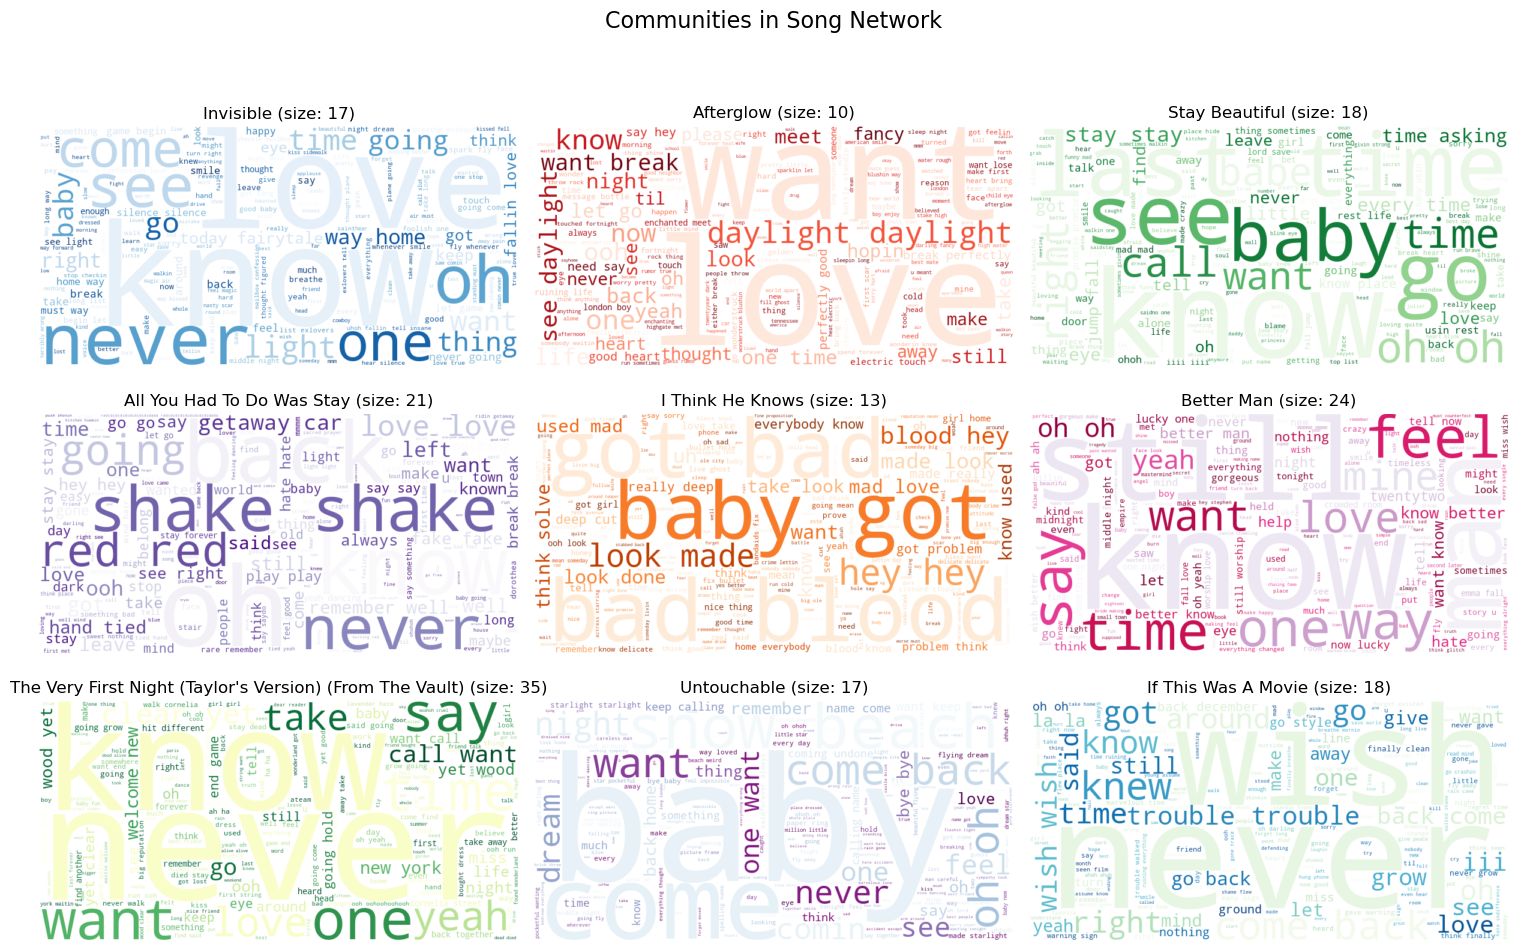

In [35]:
# Extract lyrics for each community
community_lyrics = {}
for comm_id, nodes in communities.items():
    community_lyrics[comm_id] = " ".join(
        updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    )

# Define the number of rows and columns for the grid layout
num_communities = len(community_lyrics)
rows = (num_communities // 3) + (1 if num_communities % 3 else 0)
cols = min(3, num_communities)

# Create a colormap for different colors per community
# cmap = cm.get_cmap("tab10", num_communities)
colormap_names = ["Blues", "Reds", "Greens", "Purples", "Oranges", "PuRd",  "YlGn", "BuPu", "GnBu"]

# Generate the word clouds and organize them in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, (comm_id, lyrics) in enumerate(community_lyrics.items()):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap_names[i] ,
        random_state=42 ,
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(
        f"{community_names[comm_id]} (size: {len(communities[comm_id])})",
        color='black'  # Set the title color to match the community color
    )

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Communities in Song Network", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()


In [36]:
# Function to compute word frequencies for each community
def compute_word_frequencies(community_lyrics, communities):
    community_word_data = []
    for comm_id, nodes in communities.items():
        # Tokenize lyrics for each song in the community
        community_songs = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in community_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the community
        community_word_data.append({
            "Community": f"{comm_id}: {community_names[comm_id]}",
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(communities[comm_id])
        })

    return community_word_data

# Compute word frequencies for all communities
community_word_data = compute_word_frequencies(community_lyrics, communities)

# Convert to a DataFrame for visualization
df = pd.DataFrame(community_word_data)

# Extract the numeric prefix from the "Community" column and sort by it
df['Community Index'] = df['Community'].str.extract(r'^(\d+):', expand=False).astype(int)
df = df.sort_values(by='Community Index').drop(columns=['Community Index'])

# Reset the index after sorting
df = df.reset_index(drop=True)

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)  


display(df)


Community  \
0                                                 0: Invisible   
1                                                 1: Afterglow   
2                                            2: Stay Beautiful   
3                                3: All You Had To Do Was Stay   
4                                          4: I Think He Knows   
5                                                5: Better Man   
6  6: The Very First Night (Taylor's Version) (From The Vault)   
7                                               7: Untouchable   
8                                       8: If This Was A Movie   

                                      Most Common Words (Total Number)  \
0         [(love, 82), (never, 62), (know, 57), (way, 53), (like, 47)]   
1     [(want, 64), (love, 56), (daylight, 40), (would, 28), (one, 27)]   
2          [(time, 106), (know, 80), (oh, 68), (baby, 51), (last, 44)]   
3            [(oh, 76), (love, 73), (shake, 70), (like, 66), (go, 51)]   
4          [(got, 142), (hey, 116), (know, 84), (look, 84), (bad, 74)]   
5         [(know, 124), (like, 101), (would, 96), (man, 57), (oh, 56)]   
6  [(want, 120), (never, 110), (would, 110), (like, 108), (know, 100)]   
7          [(like, 103), (oh, 84), (come, 80), (want, 62), (baby, 49)]   
8         [(would, 110), (wish, 88), (never, 86), (back, 72), (i, 72)]   

                                        Top Words by Song Presence  Size  
0      [(know, 14), (love, 13), (oh, 13), (like, 13), (never, 12)]    17  
1           [(love, 9), (want, 8), (like, 8), (back, 7), (now, 6)]    10  
2         [(oh, 13), (know, 13), (you, 13), (time, 12), (got, 11)]    18  
3      [(oh, 17), (like, 15), (could, 14), (know, 13), (back, 13)]    21  
4         [(like, 12), (know, 10), (got, 10), (think, 9), (oh, 9)]    13  
5     [(like, 21), (know, 20), (love, 16), (way, 14), (would, 14)]    24  
6    [(know, 26), (like, 25), (would, 23), (never, 22), (say, 21)]    35  
7       [(like, 16), (oh, 13), (would, 12), (back, 11), (you, 11)]    17  
8  [(would, 14), (know, 14), (never, 13), (could, 11), (like, 11)]    18

This table highlights key patterns in the communities formed within the song network. Communities with more songs, such as *"The Very First Night (Taylor’s Version) (From The Vault)"* (35 songs), demonstrate higher cohesion, as seen in their shared common words like *"know"* and *"like"* across numerous songs. This suggests strong thematic connections within larger communities.

Interestingly, communities with fewer songs, such as *"Afterglow"* (10 songs), still exhibit distinctive common words like *"want"* and *"love"*, but these words are less prevalent across the songs, reflecting a lower degree of thematic overlap. This implies smaller communities might explore more niche or varied topics.

The table also reveals a balance between shared themes and individuality. For example, while *"Invisible"* (17 songs) emphasizes universally relatable words like *"love"* and *"never"*, communities like *"Stay Beautiful"* focus on unique terms like *"time"* and *"baby"*, potentially indicating a more specific lyrical focus.

Overall, the size of a community correlates with its connectivity and thematic density. Larger communities tend to have higher internal cohesion through shared words, whereas smaller ones exhibit a mix of distinct and shared lyrical themes. This reflects the diversity in song topics and their grouping into interconnected communities.

The Top Words by Song Presence column shows how often a word appears across songs in a community. For example, in Community 0, words like never and love appear in most songs, indicating strong cohesion and a clear shared theme.

In [37]:
# Prepare the data for the table
community_metrics = []

for comm_id, nodes in communities.items():
    lyrics = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    
    # Calculate metrics
    num_songs = len(nodes)
    word_counts = [len(song.split()) for song in lyrics]
    num_words = sum(word_counts) / len(word_counts) if word_counts else 0
    unique_word_counts = [len(set(song.split())) for song in lyrics]
    num_unique = sum(unique_word_counts) / len(unique_word_counts) if unique_word_counts else 0
    percentage_unique = num_unique / num_words if num_words else 0
    average_length = sum(len(word) for song in lyrics for word in song.split()) / sum(word_counts) if word_counts else 0
    
    # Get the average degree in the community
    subgraph = gcc.subgraph(nodes)
    degrees = [degree for _, degree in subgraph.degree()]
    average_degree = sum(degrees) / len(degrees) if degrees else 0
    
    # Find the most common words
    all_words = Counter(word for song in lyrics for word in song.split())
    common_words = [f"{word} ({count})" for word, count in all_words.most_common(5)]
    
    # Append metrics for this community
    community_metrics.append({
        "Community": f"{comm_id}: {community_names[comm_id]}",
        "num_songs": num_songs,
        "num_words": round(num_words, 2),
        "num_unique": round(num_unique, 2),
        "percentage_unique": round(percentage_unique, 2),
        "average_length": round(average_length, 2),
        "average_degree": round(average_degree, 2),
        "common_words": ", ".join(common_words)
    })

# Create a DataFrame for the table
community_metrics_df = pd.DataFrame(community_metrics)

display(community_metrics_df)


Community  num_songs  \
0                                                 0: Invisible         17   
1                                                 1: Afterglow         10   
2                                            2: Stay Beautiful         18   
3                                3: All You Had To Do Was Stay         21   
4                                          4: I Think He Knows         13   
5                                                5: Better Man         24   
6  6: The Very First Night (Taylor's Version) (From The Vault)         35   
7                                               7: Untouchable         17   
8                                       8: If This Was A Movie         18   

   num_words  num_unique  percentage_unique  average_length  average_degree  \
0     171.29       81.12               0.47            4.80            3.65   
1     177.40       82.40               0.46            4.95            2.60   
2     160.72       75.33               0.47            4.55            2.89   
3     197.90       96.00               0.49            4.73            2.48   
4     231.54       84.08               0.36            4.43            3.69   
5     165.46       82.17               0.50            4.88            3.67   
6     186.91       88.77               0.47            4.76            3.43   
7     186.88       83.71               0.45            4.84            2.71   
8     188.28       87.22               0.46            4.77            3.00   

                                                   common_words  
0         love (82), never (62), know (57), way (53), like (47)  
1     want (64), love (56), daylight (40), would (28), one (27)  
2          time (106), know (80), oh (68), baby (51), last (44)  
3            oh (76), love (73), shake (70), like (66), go (51)  
4          got (142), hey (116), know (84), look (84), bad (74)  
5         know (124), like (101), would (96), man (57), oh (56)  
6  want (120), never (110), would (110), like (108), know (100)  
7          like (103), oh (84), come (80), want (62), baby (49)  
8         would (110), wish (88), never (86), back (72), i (72)

This table offers an insightful analysis of the song communities in terms of lexical variety, song length, and connectivity. A positive relationship is observed between the number of words and unique words, indicating that longer songs incorporate more diverse vocabulary rather than relying on repetition. Communities with higher numbers of songs also tend to have higher average degrees, reflecting denser connections due to more shared topics within the community.

Interestingly, there is a noticeable trend where communities with shorter songs tend to have higher average degrees, suggesting that shorter songs focus on more interconnected and common themes, whereas longer songs may delve into more unique or less connected topics. These patterns highlight both the cohesion within communities and the diversity in lyrical content across them.

# Compare album based communities with louvan communities.

For this comparison we will keep into account just the albumn of which we have critics reviews

Let's group the songs by album and compute their word cloud 

In [38]:
#extract the albums from the folder album_reviews
#the album names are the files names
album_metacritics = os.listdir("./data/album_reviews")
album_metacritics = [x.split(".")[0] for x in album_metacritics]

#remove _ coming from the file name
album_metacritics = [x.replace("_", " ") for x in album_metacritics]

#change the names of the albums in the metractics files so that they are the same as in the dataset
changed_albums = album_metacritics.copy()
for album in album_metacritics:
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        changed_albums[changed_albums.index(album)] = new

print(f'Number of album keeped: {len(changed_albums)}')

Number of album keeped: 16


In [39]:
changed_albums

['1989',
 "1989 (Taylor's Version)",
 'evermore',
 'Fearless',
 "Fearless (Taylor's Version)",
 'folklore',
 'Lover',
 'Midnights',
 'Red',
 "Red (Taylor's Version)",
 'reputation',
 'Speak Now',
 "Speak Now (Taylor's Version)",
 'Taylor Swift',
 'The Tortured Poets Department',
 'The Tortured Poets Department: The Anthology']

In [40]:
def belongs_to_changed_albums(albums):
    if isinstance(albums, list):  # Check if the album column is a list
        return any(album in changed_albums for album in albums)
    elif isinstance(albums, str):  # Check if it's a single string
        return albums in changed_albums
    return False  # Otherwise, return False

# Apply the filter to create a sub-dataframe
filtered_df = updated_ts_data[updated_ts_data['album'].apply(belongs_to_changed_albums)]

# Function to update the album list to only include names from changed_albums
def update_album_list(albums):
    if isinstance(albums, list):  # If it's a list, filter it
        return [album for album in albums if album in changed_albums]
    elif isinstance(albums, str):  # If it's a single string, check if it should be kept
        return [albums] if albums in changed_albums else []
    return []  # Return an empty list otherwise

# Update the album column
filtered_df['album'] = filtered_df['album'].apply(update_album_list)

# Reset index for the new dataframe
filtered_df = filtered_df.reset_index(drop=True)

print(filtered_df.shape)

(218, 28)


/tmp/ipykernel_86090/2903529644.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['album'] = filtered_df['album'].apply(update_album_list)


In [41]:
# Flatten the album column to handle lists
flattened_albums = filtered_df['album'].explode()

# Compute the number of unique albums
num_unique_albums = flattened_albums.nunique()

# Print the number of albums
print(f"Number of albums: {num_unique_albums}")

# Print the names of the albums
unique_albums = flattened_albums.unique()
print("Album names:")
for album in unique_albums:
    print(album)


Number of albums: 16
Album names:
1989 (Taylor's Version)
reputation
Taylor Swift
Lover
Red (Taylor's Version)
Midnights
1989
The Tortured Poets Department: The Anthology
The Tortured Poets Department
Fearless (Taylor's Version)
Speak Now (Taylor's Version)
evermore
Red
folklore
Speak Now
Fearless


In [42]:
# Assign each song to its communities

In [43]:
album_communities = defaultdict(list)

# Iterate through the dataframe
for _, row in filtered_df.iterrows():
    track_name = row['track_name']
    albums = row['album']  # Can be a list or a single string
    
    # If `albums` is a list, iterate through it; otherwise, treat it as a single album
    if isinstance(albums, list):
        for album in albums:
            album_communities[album].append(track_name)
    else:
        album_communities[albums].append(track_name)

# Convert defaultdict to a regular dictionary
album_communities = dict(album_communities)


In [44]:
sorted_album_communities = dict(sorted(album_communities.items(), key=lambda x: x[0]))
sorted_album_communities

{'1989': ['Bad Blood',
  'How You Get The Girl',
  'Clean',
  'I Wish You Would',
  'Welcome To New York',
  'Wildest Dreams',
  'Out Of The Woods',
  'This Love',
  'Style',
  'All You Had To Do Was Stay',
  'I Know Places',
  'Blank Space',
  'Shake It Off'],
 "1989 (Taylor's Version)": ['"Slut!" (Taylor\'s Version) (From The Vault)',
  "Bad Blood (Taylor's Version)",
  "Is It Over Now? (Taylor's Version) (From The Vault)",
  "Now That We Don't Talk (Taylor's Version) (From The Vault)",
  "Say Don't Go (Taylor's Version) (From The Vault)",
  "Suburban Legends (Taylor's Version) (From The Vault)",
  'You Are In Love',
  'How You Get The Girl',
  'Clean',
  'I Wish You Would',
  'Welcome To New York',
  'Wildest Dreams',
  'New Romantics',
  'Out Of The Woods',
  'This Love',
  'Style',
  'All You Had To Do Was Stay',
  'I Know Places',
  'Wonderland',
  'Blank Space',
  'Shake It Off'],
 'Fearless': ['Fearless',
  "You're Not Sorry",
  'The Way I Loved You',
  'The Best Day',
  'Fifte

In [45]:
# For each community (album) extract the lyrics 
album_communities_lyrics = {}
for album_name, songs in album_communities.items():
    album_communities_lyrics[album_name] = " ".join(
        filtered_df[filtered_df['track_name'].isin(songs)]['cleaned_lyrics']
    )
album_communities_lyrics

{"1989 (Taylor's Version)": 'flamingo pink sunrise boulevard clink clink young art aquamarine moonlit swimmin pool need you got lovestruck went straight head got lovesick bed love think never forget handprints wet cement adorned smoke clothes lovelorn nobody know love thorn rose pay price dressed might well lookin u call slut know might worth going drunk might well drunk love send code waitin stick stone throw froze midair everyone want him crime wrong place right time break down pullin world boy gentleman got lovestruck went straight head straight head got lovesick bed over bed love think never forget pay price guess dressed if dressed up might well lookin u lookin u call slut if call slut know might worth worth once going drunk might well drunk love half asleep takin time tangerine neon light luxury sayin love going half awake takin chance big mistake saidit might blow pretty face sayindo anyway do anyway going up call slut know might worth going drunk might well drunk love because b

In [46]:
# Sort the keys alphabetically and create a new dictionary
album_communities_lyrics_sorted = {
    key: album_communities_lyrics[key]
    for key in sorted(album_communities_lyrics.keys())
}

# Display the sorted dictionary
album_communities_lyrics_sorted


{'1989': 'because baby got bad blood know used mad love uh take look done uh because baby got bad blood uh hey hey cannot take back look uh og like doc remember that remember that tlc quite od id fact id my pov me similar iraq hate you hate critique overrate beat dark heart use basslines replace take time erase you love hear more no fear better yet respect quite sincere oh sad think good time because baby got bad blood know used mad love take look done because baby got bad blood hey got problem think solve uh made really deep cut uh and baby got bad blood hey hey remember tried write off haha remember thought would take loss remember thought would need ya follow procedure remember oh wait got amnesia season battle wound battle scar body bumped bruised stabbed back brimstone fire jumpin still life got money power got live bad blood haha oh sad think good time because baby got bad blood hey hey hey hey know used mad love hey hey hey hey take look done hey hey hey hey because baby got bad

IndexError: list index out of range

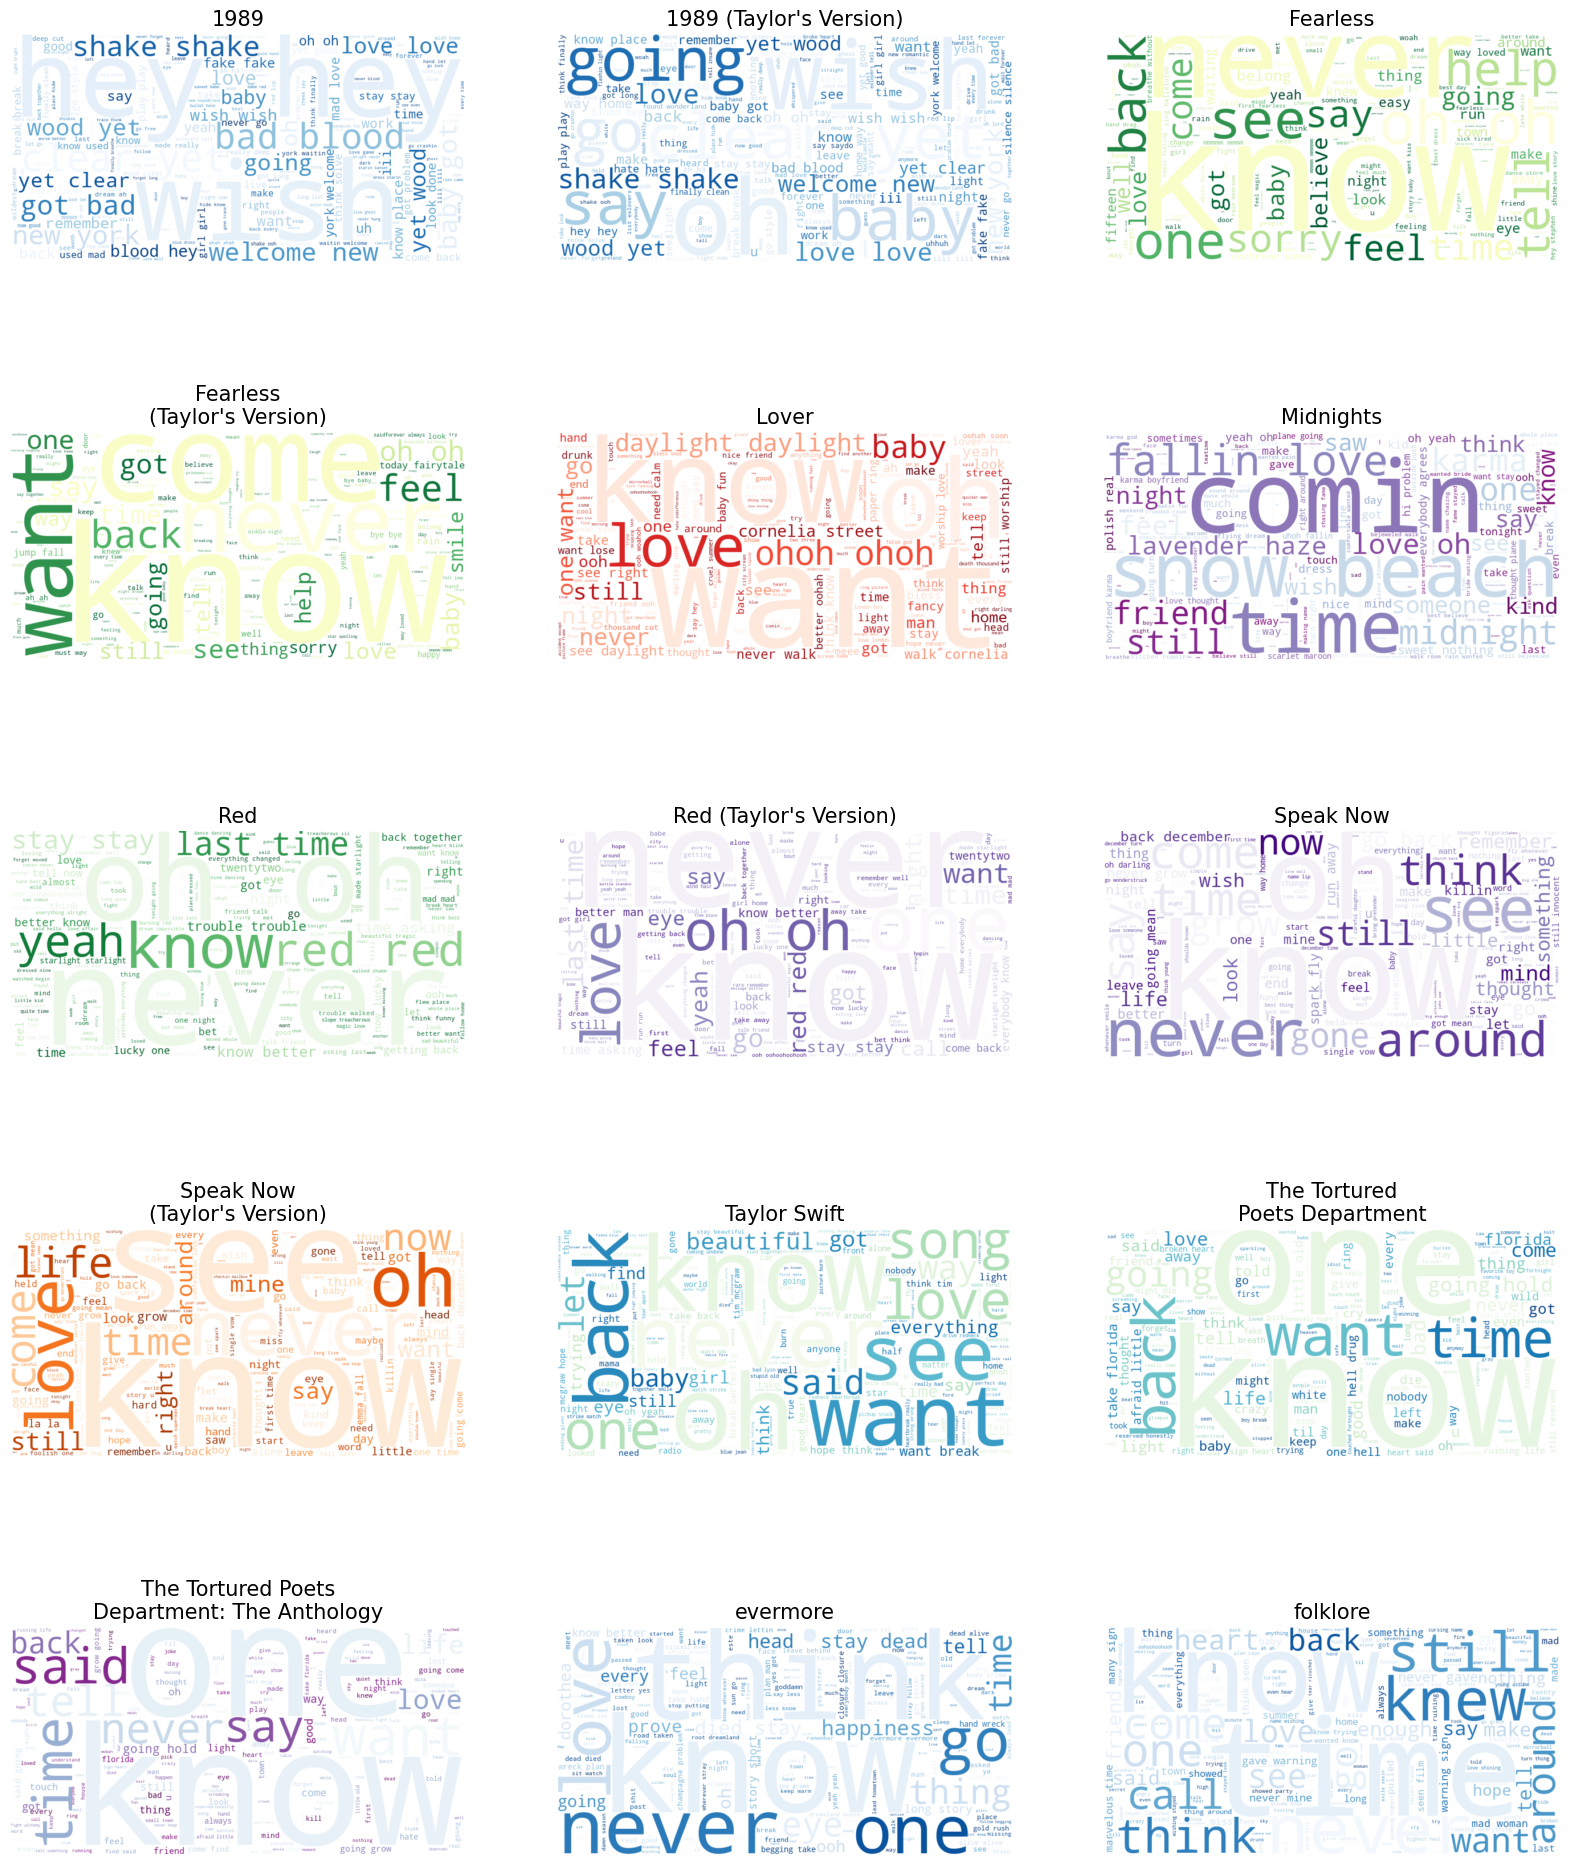

In [47]:
# Define a list of colormaps
colormap_names = ["Blues", "Blues", 
                  "YlGn", "YlGn",
                  "Reds", 
                  "BuPu",
                  "Greens", 
                  "Purples", "Purples", 
                  "Oranges", 
                  "GnBu", "GnBu",
                  "BuPu", 
                  "Blues", "Blues", 
                ]

# Define rows and columns for the grid
rows = 5
cols = 3

# Create the grid plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 25))
axes = axes.flatten()

# Function to wrap album titles more elegantly
def wrap_title(title, max_length=25):
    if len(title) <= max_length:
        return title
    words = title.split()
    mid_point = len(words) // 2
    line_1 = " ".join(words[:mid_point])
    line_2 = " ".join(words[mid_point:])
    return f"{line_1}\n{line_2}"

# Plot each word cloud
for i, (album, lyrics) in enumerate(album_communities_lyrics_sorted.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap_names[i],
        random_state=42
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    # Put in two lines if the title if it is too long
    max_length = 25
    formatted_title = wrap_title(album)
    axes[i].set_title(formatted_title, fontsize=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Word Clouds for Albums", fontsize=29)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()



In [48]:
# Calculate the number of songs in each album community
album_song_counts = {album: len(set(songs)) for album, songs in album_communities.items()}

# Convert to a DataFrame for better visualization
album_song_counts_df = pd.DataFrame(list(album_song_counts.items()), columns=["Album", "Number of Songs"])

# Sort the DataFrame by the number of songs in descending order
album_song_counts_df = album_song_counts_df.sort_values(by="Number of Songs", ascending=False).reset_index(drop=True)

# Display the DataFrame
display(album_song_counts_df)


Album  Number of Songs
0   The Tortured Poets Department: The Anthology               31
1                         Red (Taylor's Version)               29
2                    Fearless (Taylor's Version)               25
3                   Speak Now (Taylor's Version)               22
4                        1989 (Taylor's Version)               21
5                                          Lover               18
6                                            Red               16
7                  The Tortured Poets Department               16
8                                       folklore               16
9                                       evermore               15
10                                    reputation               15
11                                  Taylor Swift               14
12                                     Speak Now               14
13                                     Midnights               13
14                                          1989               13
15                                      Fearless               13

In [49]:
# Function to compute word frequencies for album-based communities
def compute_word_frequencies_albums(album_lyrics, album_communities):
    album_word_data = []
    for album_name, songs in album_communities.items():
        # Ensure `songs` is always treated as a list
        if isinstance(songs, str):
            flat_song_list = [songs]  # If it's a single string, wrap it in a list
        else:
            flat_song_list = list(songs)  # Otherwise, convert it to a list (if it's not already)

        # Tokenize lyrics for each song in the album
        album_songs = filtered_df[filtered_df['track_name'].isin(flat_song_list)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in album_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the album
        album_word_data.append({
            "Album": album_name,
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(flat_song_list)
        })

    return album_word_data

# Compute word frequencies for all album-based communities
album_word_data = compute_word_frequencies_albums(album_communities_lyrics_sorted, sorted_album_communities)

# Convert to a DataFrame for visualization
df_album = pd.DataFrame(album_word_data)

# Sort by Album names alphabetically
df_album = df_album.sort_values(by='Album').reset_index(drop=True)

# Set pandas options for better display
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)

# Display the DataFrame
display(df_album)



Album  \
0                                           1989   
1                        1989 (Taylor's Version)   
2                                       Fearless   
3                    Fearless (Taylor's Version)   
4                                          Lover   
5                                      Midnights   
6                                            Red   
7                         Red (Taylor's Version)   
8                                      Speak Now   
9                   Speak Now (Taylor's Version)   
10                                  Taylor Swift   
11                 The Tortured Poets Department   
12  The Tortured Poets Department: The Anthology   
13                                      evermore   
14                                      folklore   
15                                    reputation   

                                   Most Common Words (Total Number)  \
0          [(i, 100), (love, 88), (hey, 83), (wish, 81), (got, 70)]   
1        [(love, 108), (i, 101), (oh, 90), (wish, 81), (shake, 70)]   
2       [(know, 61), (oh, 50), (cannot, 29), (no, 26), (never, 26)]   
3         [(know, 89), (oh, 71), (come, 57), (like, 51), (you, 45)]   
4     [(want, 88), (would, 71), (like, 67), (love, 48), (know, 48)]   
5      [(like, 52), (karma, 28), (love, 25), (comin, 25), (oh, 23)]   
6       [(like, 80), (know, 77), (time, 69), (oh, 64), (never, 57)]   
7      [(know, 142), (like, 128), (time, 104), (oh, 92), (one, 73)]   
8    [(like, 47), (know, 37), (would, 36), (never, 35), (back, 32)]   
9     [(would, 76), (like, 65), (know, 62), (see, 57), (never, 53)]   
10     [(oh, 45), (know, 37), (want, 33), (would, 28), (think, 26)]   
11      [(going, 40), (you, 38), (one, 37), (like, 36), (know, 35)]   
12     [(like, 79), (going, 77), (one, 63), (know, 59), (said, 54)]   
13  [(know, 49), (like, 48), (could, 31), (would, 30), (think, 27)]   
14   [(would, 50), (never, 46), (know, 45), (time, 45), (like, 41)]   
15     [(want, 88), (made, 53), (like, 52), (look, 48), (call, 47)]   

                                       Top Words by Song Presence  Size  
0     [(could, 11), (know, 10), (like, 10), (back, 9), (good, 8)]    13  
1   [(back, 15), (know, 14), (like, 14), (could, 13), (love, 12)]    21  
2          [(know, 11), (say, 11), (oh, 10), (like, 9), (got, 9)]    13  
3        [(know, 19), (say, 18), (oh, 17), (like, 17), (you, 16)]    25  
4       [(like, 15), (want, 12), (you, 12), (know, 11), (go, 10)]    18  
5        [(time, 9), (like, 9), (going, 7), (love, 7), (feel, 6)]    13  
6      [(time, 14), (like, 14), (know, 12), (oh, 10), (would, 9)]    16  
7    [(like, 25), (know, 24), (time, 23), (would, 18), (one, 18)]    29  
8     [(like, 13), (would, 11), (know, 11), (you, 11), (see, 10)]    14  
9   [(like, 21), (know, 19), (would, 16), (never, 16), (you, 14)]    22  
10           [(oh, 11), (know, 10), (one, 8), (way, 8), (see, 8)]    14  
11    [(one, 13), (like, 13), (say, 11), (would, 10), (know, 10)]    16  
12   [(like, 26), (one, 23), (know, 21), (would, 19), (time, 16)]    31  
13     [(would, 12), (know, 12), (like, 11), (go, 9), (could, 8)]    15  
14   [(would, 12), (know, 11), (time, 11), (like, 11), (one, 10)]    16  
15          [(oh, 13), (like, 12), (me, 10), (time, 9), (one, 9)]    15

# Recompute the louvain communities but just for the subset of the dataset belonging to the albumns for which we have critics


In [50]:
# Convert the network to an undirected graph
undirected_graph = net.to_undirected()

# Get the nodes that belong to the filtered_df dataframe
nodes_to_keep = filtered_df['track_name'].unique()

# Create a subgraph of the network with the nodes to keep
net_album = undirected_graph.subgraph(nodes_to_keep)

largest_cc = max(nx.connected_components(net_album), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")


GCC has 156 nodes and 397 edges


In [51]:
# # Detect communities in the GCC
# partition_album_net = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition_album_net.pkl", "wb") as f:
#     pickle.dump(partition_album_net, f)

In [52]:
with open("partition_album_net.pkl", "rb") as f:
    partition_album_net = pickle.load(f)

# Compute modularity for the GCC
modularity_album_net = community_louvain.modularity(partition_album_net, gcc)
print(f"Number of communities in GCC: {len(set(partition_album_net.values()))}")
print(f"Modularity value for GCC: {modularity_album_net}")

Number of communities in GCC: 10
Modularity value for GCC: 0.47077536144609855


In [53]:
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
print(community_names)

Communities named by highest-degree song:
{0: 'Invisible', 1: 'Afterglow', 2: 'Stay Beautiful', 3: 'All You Had To Do Was Stay', 4: 'I Think He Knows', 5: 'Better Man', 6: "The Very First Night (Taylor's Version) (From The Vault)", 7: 'Untouchable', 8: 'If This Was A Movie'}


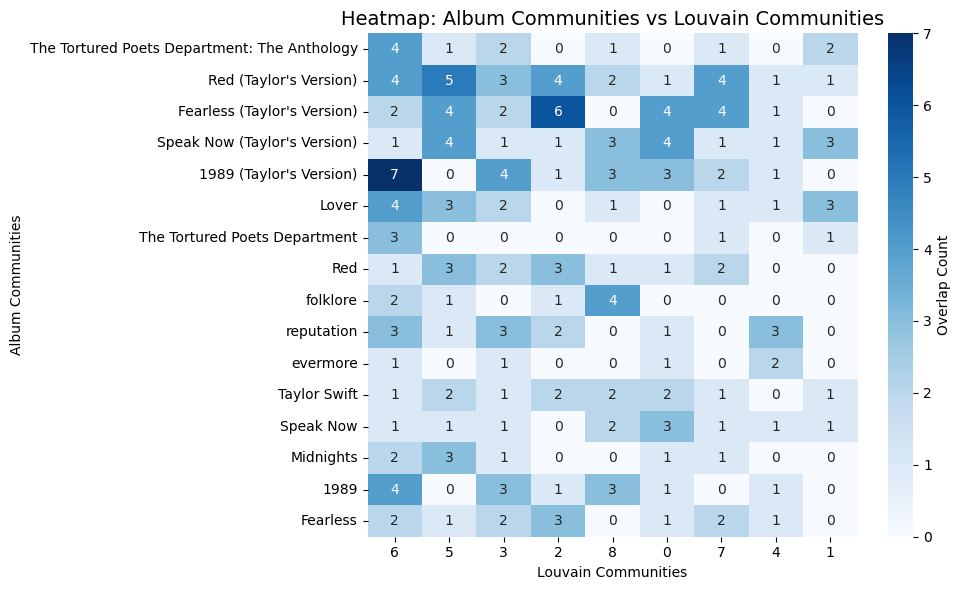

In [54]:
# Example: Compute sizes of album communities
album_sizes = {album: len(songs) for album, songs in album_communities.items()}
top_albums = sorted(album_sizes, key=album_sizes.get, reverse=True)# [:5]  # Top 5 albums

# Example: Compute sizes of Louvain communities
louvain_sizes = {community: len(nodes) for community, nodes in communities.items()}
top_louvain = sorted(louvain_sizes, key=louvain_sizes.get, reverse=True) # [:5]  # Top 5 Louvain communities

# Initialize confusion matrix
confusion_matrix = pd.DataFrame(0, index=top_albums, columns=top_louvain)

# Populate the confusion matrix
for album in top_albums:
    for louvain_comm in top_louvain:
        # Count overlap between album and Louvain communities
        album_songs = set(album_communities[album])
        louvain_songs = set(communities[louvain_comm])
        overlap = len(album_songs.intersection(louvain_songs))
        confusion_matrix.at[album, louvain_comm] = overlap

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Overlap Count'}
)
plt.title("Heatmap: Album Communities vs Louvain Communities", fontsize=14)
plt.xlabel("Louvain Communities")
plt.ylabel("Album Communities")
plt.tight_layout()
plt.show()


!!! IMPORTANT TO DISCUSS

LOUVAIN COMMUNITIES COMES FROM BIGGEST CONNECT COMPONENT GRAPH WHILE ALBUM BASED COMMUNITIES COMES FROM THE DATAFRAME SO THEY HAVE DIFFERENT SHAPE SO THE HEAT MAP IN THE ROWS DOESN'T SHOW THE SUM OF THE ELEMENTS OF THE 



COMPUTE THE ALBUM COMMUNITIES FORM THE NETWORK AS WELL 

--> CHECK IF IT IS NECESSARY TO TAK EJUST THE CONNECTED COMPONENTS 

# Centrality

In [55]:
# calculate centrality measures
degree = dict(net.degree())
betweenness = nx.betweenness_centrality(net)
closeness = nx.closeness_centrality(net)
eigenvector = nx.eigenvector_centrality(net)

# sort the nodes by centrality measures
degree_sorted = sorted(degree, key=degree.get, reverse=True)
betweenness_sorted = sorted(betweenness, key=betweenness.get, reverse=True)
closeness_sorted = sorted(closeness, key=closeness.get, reverse=True)
eigenvector_sorted = sorted(eigenvector, key=eigenvector.get, reverse=True)

# print the top 5 nodes for each centrality measure with their centrality scores
print("Degree")
for node in degree_sorted[:5]:
    print(f"{node}: {degree[node]}")
print('---------------------------------')
print("Betweenness")
for node in betweenness_sorted[:5]:
    print(f"{node}: {betweenness[node]}")
print('---------------------------------')
print("Closeness")
for node in closeness_sorted[:5]:
    print(f"{node}: {closeness[node]}")
print('---------------------------------')
print("Eigenvector")
for node in eigenvector_sorted[:5]:
    print(f"{node}: {eigenvector[node]}")

Degree
All You Had To Do Was Stay: 27
The Very First Night (Taylor's Version) (From The Vault): 26
22: 26
Better Man: 26
Invisible: 25
---------------------------------
Betweenness
22: 0.016665606839756722
All You Had To Do Was Stay: 0.01545921029111301
If This Was A Movie: 0.014379143094615748
Better Man: 0.013137777296740646
Haunted: 0.011278523452508267
---------------------------------
Closeness
The Very First Night (Taylor's Version) (From The Vault): 0.16066831428277212
Don't You (Taylor's Version) (From The Vault): 0.13898538737248414
Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault): 0.13538548310121915
I Can See You (Taylor's Version) (From The Vault): 0.13283632666892578
Nothing New (feat. Phoebe Bridgers) (Taylor's Version) (From The Vault): 0.12939491064491065
---------------------------------
Eigenvector
The Very First Night (Taylor's Version) (From The Vault): 0.5116636459522789
Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault): 0.4161548534942395
Foreve

In [57]:
# Create a DataFrame for analysis
centrality_data = pd.DataFrame({
    'song_id': degree.keys(),
    'degree': degree.values(),
    'betweenness': betweenness.values(),
    'closeness': closeness.values(),
    'eigenvector': eigenvector.values()
})

# Add the number of streams to the DataFrame
streams = nx.get_node_attributes(net, 'spotify_streams')
streams_data = pd.DataFrame(streams.items(), columns=['song_id', 'streams'])

# Merge centrality measures with streams data
centrality_data = centrality_data.merge(streams_data, on='song_id')

centrality_data.head()

# print how many rows and columns the DataFrame has
print(centrality_data.shape)
# Sum the streams if a node has a list with more than one value
centrality_data['streams'] = centrality_data['streams'].apply(lambda x: sum(x) if isinstance(x, list) else x)

# print the updated DataFrame
centrality_data.head()

(235, 6)


song_id  degree  betweenness  \
0  "Slut!" (Taylor's Version) (From The Vault)       3     0.000000   
1                             ...Ready For It?      10     0.000764   
2                       A Perfectly Good Heart       9     0.000000   
3                        A Place in this World       3     0.000000   
4                                    Afterglow      12     0.003023   

   closeness   eigenvector    streams  
0   0.082824  6.526134e-02  239579759  
1   0.080247  3.958429e-02  695895392  
2   0.000000  1.767125e-29   25204096  
3   0.006410  5.644276e-10   40680546  
4   0.092398  6.447317e-02  368409481

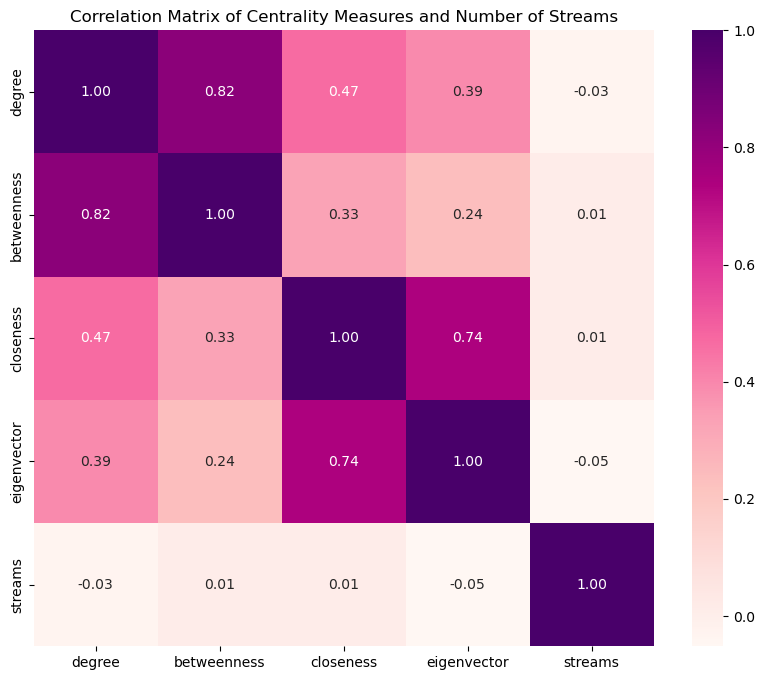

In [59]:
# calculate correlation between centrality measures
correlation = centrality_data.select_dtypes(include=[np.number]).corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Matrix of Centrality Measures and Number of Streams')
plt.show()

! MAYBE CHANGE THE WAY IN WHICH POPULAR AND LESS POPULAR ARE COMPUTED 

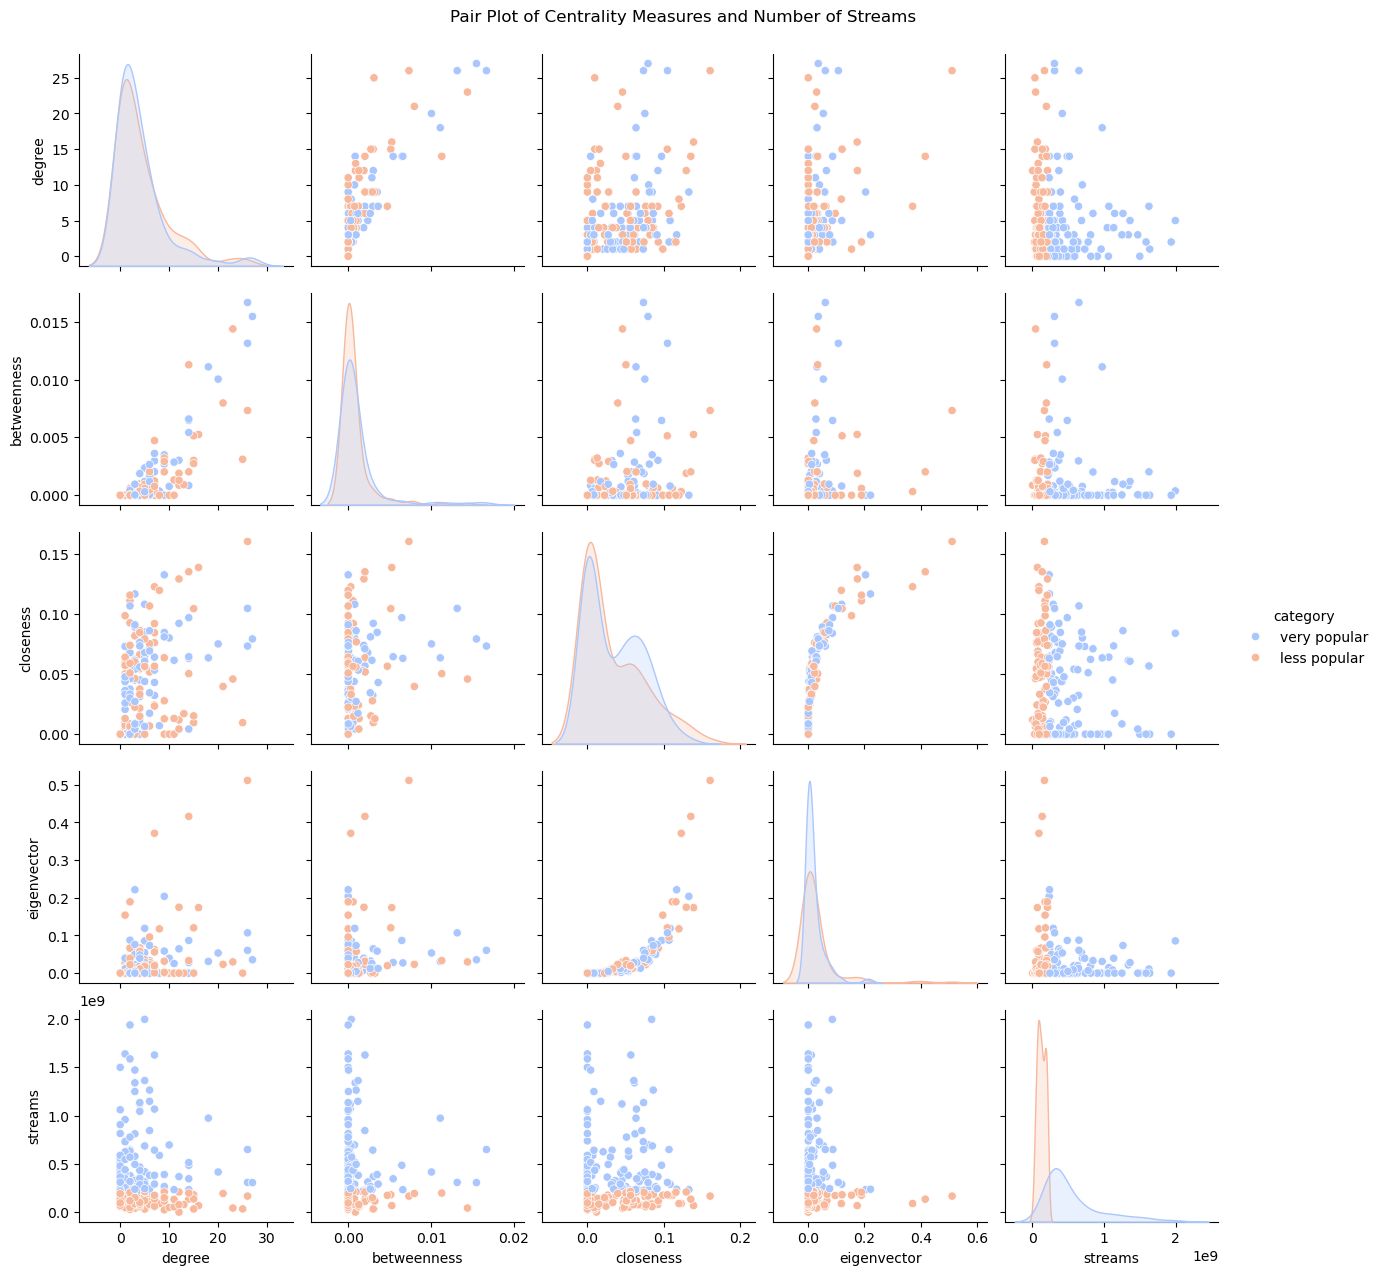

In [60]:
# Assuming we have a categorical variable to use for hue, e.g., 'category'
# You can create a dummy categorical variable for demonstration
centrality_data['category'] = np.where(centrality_data['streams'] > centrality_data['streams'].median(), 'very popular', 'less popular')

# Create a pair plot using the hue parameter
sns.pairplot(centrality_data[['degree', 'betweenness', 'closeness', 'eigenvector', 'streams', 'category']],
             hue='category', palette='coolwarm')
plt.suptitle('Pair Plot of Centrality Measures and Number of Streams', y=1.02)
plt.show()

### Analysis of Results and Conclusions

**Categorization Justification**:
The songs were categorized into "very popular" and "less popular" based on the median number of Spotify streams. Songs with streams above the median are classified as "very popular," while those below are "less popular." This approach ensures a balanced distribution and utilizes a robust measure of central tendency.

**Impact of Re-released Songs**:
It's important to note that some of Taylor Swift's popular songs might be those she re-released due to her issues with her former record label. These re-releases have their streams summed up, potentially boosting their popularity metrics.

### Analysis of Pair Plot

1. **Degree Centrality vs. Streams**:
   - **Observation**: There is a slight negative correlation between degree centrality and the number of streams, especially for the most popular songs.
   - **Conclusion**: Songs with higher degree centrality are not necessarily the ones with the highest number of streams. This suggests that simply having more connections (or shared top words with other songs) does not directly correlate with popularity. The popular songs might not be those with the highest number of connections but those that are strategically well-positioned or have other enhancing factors.

2. **Betweenness Centrality vs. Streams**:
   - **Observation**: Betweenness centrality is very low for most songs and does not show a clear pattern with the number of streams.
   - **Conclusion**: Betweenness centrality does not seem to be a strong indicator of a song's popularity. This indicates that acting as a bridge between songs (in terms of shared top words) does not significantly impact the number of streams. 

3. **Closeness Centrality vs. Streams**:
   - **Observation**: There is a noticeable clustering of higher streams with higher closeness centrality, but it's not a strong trend.
   - **Conclusion**: Songs that are more central in terms of closeness centrality (i.e., closer to all other songs in terms of shared words) might have a slight advantage in gaining streams. This suggests a moderate relationship where more central songs have a better reach or influence, possibly aiding in their popularity.

4. **Eigenvector Centrality vs. Streams**:
   - **Observation**: There is a slight negative correlation between eigenvector centrality and the number of streams.
   - **Conclusion**: Songs that are connected to other highly connected songs (high eigenvector centrality) are not necessarily the ones with the most streams. This indicates that being connected to other popular songs does not guarantee higher streams, pointing to the complexity of factors driving song popularity beyond mere network position.

5. **Streams Distribution**:
   - **Observation**: The distribution of streams shows a clear distinction between the very popular and less popular songs. Very popular songs are more spread out, while less popular songs are clustered at the lower end of the streams spectrum.
   - **Conclusion**: There is a clear bifurcation in the popularity of songs, with a small number of songs achieving very high streams and a larger number of songs with lower streams. This highlights the disparity in popularity where a few songs dominate in streams.

### Consideration of Re-released Songs

Given that some of Taylor Swift’s songs were re-released and their streams were summed, these songs likely appear more popular in the dataset:

- **Impact of Re-releases**: Re-released songs might have artificially inflated streams due to summing streams across different versions. This could skew the centrality measures, particularly degree and closeness, making these songs appear more central or well-connected due to multiple releases.
- **Strategic Positioning**: Re-released songs, through their multiple versions and summed streams, could gain better network positioning, enhancing their visibility and stream counts.

### General Conclusions

1. **Centrality Measures and Popularity**:
   - Centrality measures alone do not show strong correlations with the number of streams. This suggests that factors beyond network centrality, such as marketing efforts, song quality, and the artist's popularity at the time of release, play more significant roles in determining a song's popularity.
   - Closeness centrality shows a slight advantage for popular songs, indicating that being more central in terms of shared top words can help in gaining streams but is not the sole factor.

2. **Impact of Re-released Songs**:
   - The re-released songs likely contribute to the higher stream counts and centrality measures observed in very popular songs. Taylor Swift’s strategy of re-releasing songs has effectively boosted their popularity by increasing their connectivity and centrality within the network.

3. **Need for Multivariate Analysis**:
   - To gain more insights, consider additional variables like release year, album, and marketing efforts. A multivariate regression analysis could help identify key predictors of streams, offering a more comprehensive understanding of what drives song popularity.

In summary, while network centrality measures provide some insights, they do not fully explain song popularity. The re-release strategy and other external factors significantly contribute to the observed popularity trends.

# Sentiment analysis of the lyrics

In [76]:
# iterate through the data and sum the spotify streams of the songs if it's a list
for i,row in updated_ts_data.iterrows():
    if type(row['spotify_streams']) == list:
        updated_ts_data.at[i,'spotify_streams'] = sum(row['spotify_streams'])
    else:
        updated_ts_data.at[i,'spotify_streams'] = row['spotify_streams']

updated_ts_data['spotify_streams'] = updated_ts_data['spotify_streams'].astype(int)

We build a function that takes the LabMT wordlist as a parameter and it returns the dictionary with the words in the file and their correspondant sentiment score.

In [78]:
def sentiment_dictionary(LabMT = 'data/Data_Set_S1.txt'):
    """
    This function loads the LabMT wordlist and creates a dictionary of words and their happiness values.
    labMT: str, the path to the LabMT wordlist
    """
    #load the LabMT wordlist from Data_Set_S1.txt
    with open(LabMT, 'r') as f:
        lines = f.readlines()
    
    #remove the first foour lines 
    lines = lines[4:]

    #create a dictionary of words and their happiness values
    word_dict = defaultdict(float)
    for line in lines:
        line = line.split('\t')
        word = line[0]
        happiness = float(line[2])
        #print(word, happiness)
        word_dict[word] = happiness

    return word_dict

We build a function to clean and transfrom the lyrics into tokens.

In [79]:
def lyrics_to_tokens(lyrics):
    """
    This function takes a string of lyrics and returns a list of tokens.
    lyrics: str, a string of lyrics    
    """
    #convert to lower case
    lyrics = lyrics.lower()
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    #remove punctuation
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    #tokenize the lyrics
    tokens = word_tokenize(lyrics)

    tokens = [word for word in tokens if word not in stop_words]
    #lemmatize the tokens
    #lemmatizer = WordNetLemmatizer() We do not lemmatize the words because the LabMT wordlist is not lemmatized
    return tokens

Here we build a function that calculates the sentiment of a song based on the word dictionary previously obtained. To calculate the sentiment score we use the weighted sum, so that the words contribute to the sentiment score based on the frequency in which they appear. Furthermore, this function also returns the words that are present in the LabMT wordlist with the scores and their frequency in the song.

In [80]:
#function to calculate sentiment given a list of tokens based on the LabMT wordlist dictionary
def sentiment_with_words(lyrics, word_dict):
    """
    This function calculates the sentiment of a list of tokens based on the LabMT wordlist dictionary. 
    It also returns the words that are in the LabMT wordlist, their frequency and scores
    tokens: list, a list of tokens
    word_dict: dict, a dictionary of words and their happiness values
    """
    tokens = lyrics_to_tokens(lyrics)
    #calculate the frequency of each word in the tokens list
    freq = defaultdict(int)
    for token in tokens:
        freq[token] += 1

    word_list = []
    #calculate the happiness score of the tokens list
    score = 0
    count = 0
    for word in freq:
        if word in word_dict:
            word_list.append((word, freq[word], word_dict[word]))
            score += freq[word] * word_dict[word]
            count += freq[word]
            sentiment = score / count
    return sentiment, word_list

Next we build the function that iterates through the dataframe and obtains the sentiment score for each song (using the previously defined function) and also returns the three happiest and saddest words in each song

In [81]:
def calculate_sentiments_with_details(df, low_threshold, high_threshold):
    """
    This function calculates the sentiment of each track in the dataframe and returns the happiest and saddest words.
    df: pandas dataframe, a dataframe with a column of track lyrics
    """
    # add the three happiest words and three saddest words to the sentiments_dict with their scores and frequencies
    word_dict = sentiment_dictionary()
    sentiments_dict = defaultdict(dict)
    for index, row in df.iterrows():
        lyrics = row['track_lyrics']
        if type(lyrics) == list:
            for lyric in lyrics:
                sentiment_score, word_list = sentiment_with_words(lyric, word_dict)
                sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

                #obtain the percentage of sentiment category
                happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
                sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
                neutral_percentage = 100 - happy_percentage - sad_percentage
                sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage

                #order the word_list by score
                word_list = sorted(word_list, key=lambda x: x[2])
                sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
                sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]
        else:
            sentiment_score, word_list = sentiment_with_words(lyrics, word_dict)
            sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

            #obtain the percentage of sentiment category
            happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
            sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
            neutral_percentage = 100 - happy_percentage - sad_percentage
            sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage
            

            #order the word_list by score
            word_list = sorted(word_list, key=lambda x: x[2])
            sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
            sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]

    return sentiments_dict

In [82]:
#obtain the dictionary with the words and their happiness values
word_dict = sentiment_dictionary()

sentiment_values = np.array(list(word_dict.values()))

#calculate the thresholds for three categories: sad, neutral and happy
low_threshold = np.percentile(sentiment_values, 33)  
high_threshold = np.percentile(sentiment_values, 66)

print(f'The words with a sentiment score below {low_threshold} are considered sad')
print(f'The words with a sentiment score between {low_threshold} and {high_threshold} are considered neutral')
print(f'The words with a sentiment score above {high_threshold} are considered happy')

The words with a sentiment score below 5.08 are considered sad
The words with a sentiment score between 5.08 and 5.78 are considered neutral
The words with a sentiment score above 5.78 are considered happy


In [83]:
song_sentiments_with_details = calculate_sentiments_with_details(updated_ts_data, low_threshold, high_threshold)

In [84]:
#calculate the stats of all the sentiments
sentiments = [value['sentiment'] for value in song_sentiments_with_details.values()]
sentiments = np.array(sentiments)

print('Mean sentiment:', np.mean(sentiments))
print('Median sentiment:', np.median(sentiments))
print('Standard deviation sentiment:', np.std(sentiments))
print('Minimum sentiment:', np.min(sentiments))
print('Maximum sentiment:', np.max(sentiments))

Mean sentiment: 5.51136170212766
Median sentiment: 5.53
Standard deviation sentiment: 0.24309497535718683
Minimum sentiment: 4.61
Maximum sentiment: 6.24


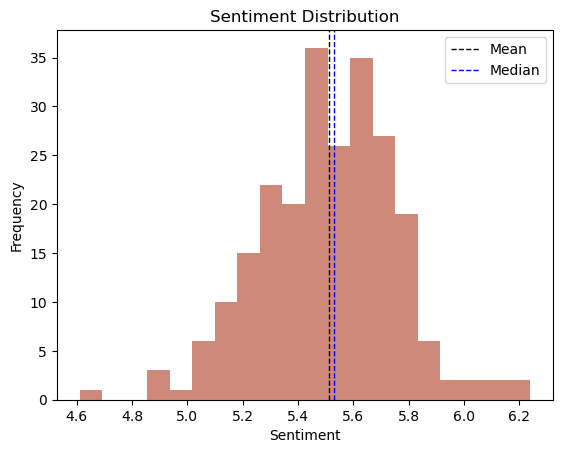

In [85]:
#plot the distribution of the sentiments adding stadistics and a legend
plt.hist(sentiments, bins=20, color='#cf897a')
plt.axvline(np.mean(sentiments), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.median(sentiments), color='blue', linestyle='dashed', linewidth=1)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend(['Mean', 'Median'])
plt.show()

In [86]:
#calculate the stats of the happiest words. We will use the happiest words from all the songs taking into account that they may be repeated
happiest_words = []
for value in song_sentiments_with_details.values():
    happiest_words.extend([word[0] for word in value['happiest words']])
happiest_words = np.array(happiest_words)

In [87]:
rows = []

for song, data in song_sentiments_with_details.items():
    rows.append({
        "Song": song,
        "Sentiment": data["sentiment"],
        "Happy %": data["happy_percentage"],
        "Sad %": data["sad_percentage"],
        "Neutral %": data["neutral_percentage"],
        "Happiest Words": ", ".join([f"{word} ({score})" for word, _, score in data["happiest words"]]),
        "Saddest Words": ", ".join([f"{word} ({score})" for word, _, score in data["saddest words"]]),
    })

sentiment_df = pd.DataFrame(rows)

sentiment_df.head()

Song  Sentiment  Happy %  Sad %  \
0  "Slut!" (Taylor's Version) (From The Vault)       5.48    40.48  38.10   
1                             ...Ready For It?       5.73    41.77  35.44   
2                       A Perfectly Good Heart       5.50    37.50  32.50   
3                        A Place in this World       5.38    39.66  22.41   
4                                    Afterglow       5.01    34.21  39.47   

   Neutral %                               Happiest Words  \
0      21.42      rose (7.32), pretty (7.32), love (8.42)   
1      22.79     dreams (7.44), loved (7.96), love (8.42)   
2      30.00  heart (7.22), perfectly (7.28), love (8.42)   
3      37.93   life (7.32), lucky (7.68), sunshine (7.94)   
4      26.32       like (7.22), heart (7.22), love (8.42)   

                                    Saddest Words  
0         crime (2.2), ill (2.42), mistake (2.78)  
1  failure (2.06), killer (2.42), stealing (2.46)  
2            tear (3.1), scar (3.28), cant (3.48)  
3          ill (2.42), wrong (3.14), alone (3.32)  
4         jail (1.76), crying (2.04), hurt (2.18)

To be able to analyze these results, we will plot only her most popular songs.

In [89]:
#obtain the 15 most popular words using sentiment_df and the spotify streams in loaded_df
sentiment_df['spotify_streams'] = updated_ts_data['spotify_streams']
sentiment_df = sentiment_df.sort_values(by='spotify_streams', ascending=False)

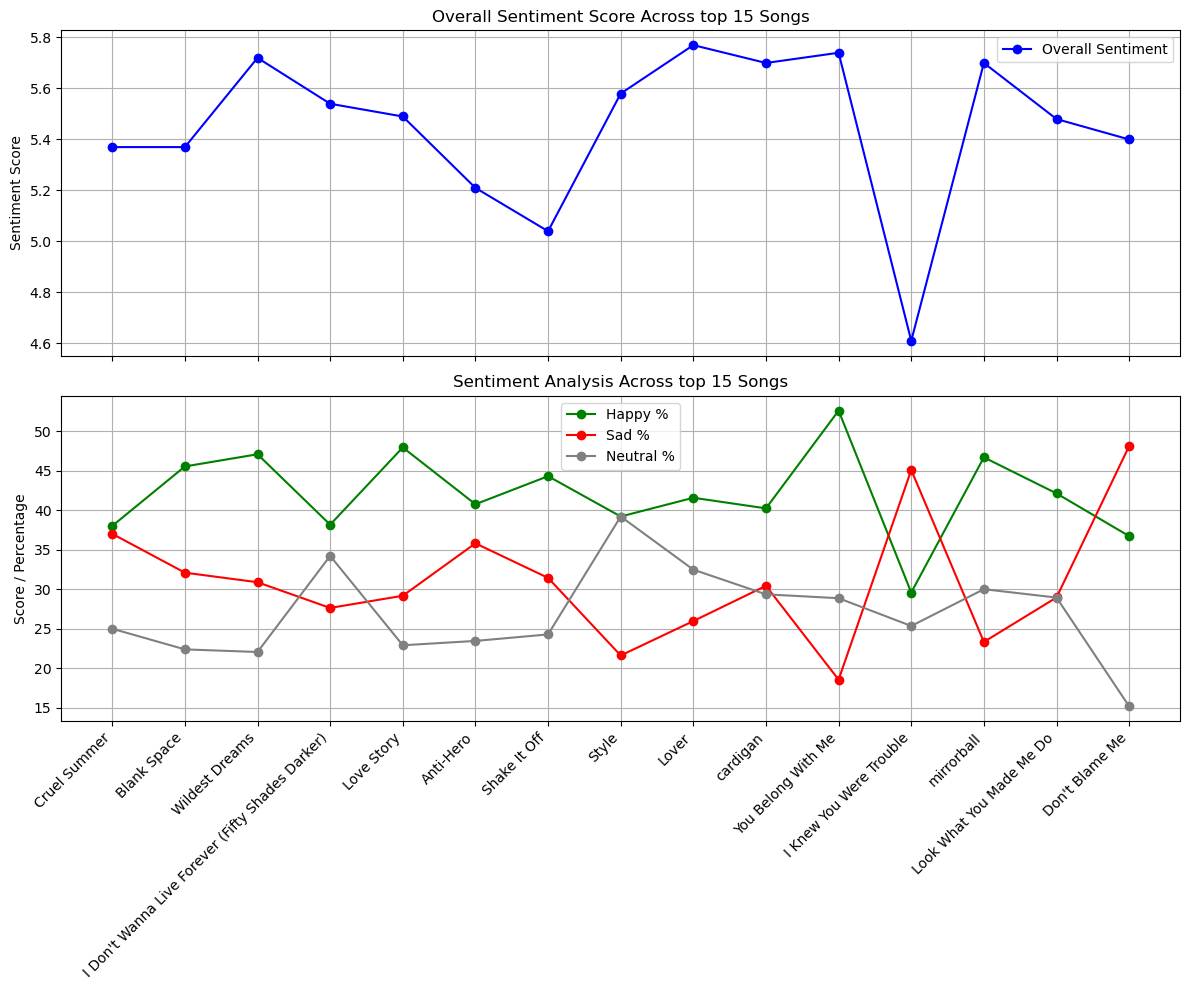

In [90]:
#plot the sentiment percentages of the 15 most popular songs
sentiment_df = sentiment_df.head(15)
songs = sentiment_df["Song"]
happy = sentiment_df["Happy %"]
sad = sentiment_df["Sad %"]
neutral = sentiment_df["Neutral %"]
sentiment = sentiment_df["Sentiment"]


fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(songs, sentiment, marker="o", color="blue", label="Overall Sentiment")
axes[0].set_title("Overall Sentiment Score Across top 15 Songs")
axes[0].set_ylabel("Sentiment Score")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(songs, happy, marker="o", label="Happy %", color="green")
axes[1].plot(songs, sad, marker="o", label="Sad %", color="red")
axes[1].plot(songs, neutral, marker="o", label="Neutral %", color="gray")

axes[1].set_title("Sentiment Analysis Across top 15 Songs")
axes[1].set_ylabel("Score / Percentage")
#axes[1].xticks(rotation=45, ha="right")
axes[1].legend()
axes[1].grid(True)
#axes[1].tight_layout()

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Correlation between streams and metacritic score

First, we will go through the original dataset. We will only keep the songs that are included in the albums that we have reviews for. 
To be able to do this, we first need to know the albums that are available in metacritic.

In [92]:
avg_scores = {}
for album in os.listdir("./data/album_reviews"):
    df = pd.read_csv(f"./data/album_reviews/{album}")
    avg_score = df['score'].mean()
    avg_scores[album.split(".")[0].replace("_", " ")] = avg_score

In [93]:
# change the names of the albums in the metractics files so that they are the same as in the dataset
# repeat the procedure for the dict keys
new_keys = list(avg_scores.keys())
for album in avg_scores.keys():
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        new_keys[new_keys.index(album)] = new

#change the keys of the dict
avg_scores = dict(zip(new_keys, avg_scores.values()))

We now can clean the dataset to keep only the songs that we are interested in.

In [95]:
print(f'The original dataset has {len(data)} songs')
albums = data['album'].unique()

#remove the albums that are in metacritics and not in the network
albums = [x for x in albums if x in changed_albums]

# go through data and keep only the songs which album is in the new list
data = data[data['album'].isin(albums)]
print(f'The dataset with the reviewed album has {len(data)} songs')

The dataset with the reviewed album has 294 songs


To continue with the analysis, we will aggregate the spotify streams of each album.

In [101]:
# new dataset with each album, the average score and the number of streams of the songs in the album
metacritics_scores = pd.DataFrame(columns = ['album', 'avg_score', 'spotify_streams'])

for album in albums:
    # get the average score of the album
    avg_score = avg_scores[album]
    # get the streams of the songs in the album, remove the points and convert to int
    streams = data[data['album'] == album]['spotify_streams'].str.replace('.', '').astype(int).sum()
    
    # add all the data to the new dataset
    metacritics_scores = pd.concat([metacritics_scores, pd.DataFrame({'album': [album], 'avg_score': [avg_score], 'spotify_streams': [streams]})], ignore_index=True)

Correlation between average score and Spotify streams: 0.09


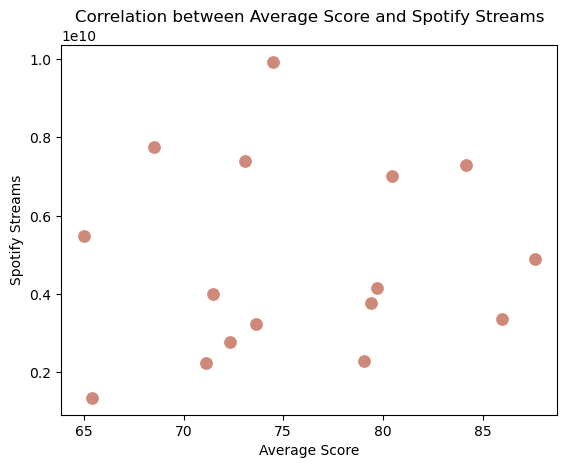

In [97]:
correlation = metacritics_scores['avg_score'].corr(metacritics_scores['spotify_streams'])
print(f'Correlation between average score and Spotify streams: {correlation:.2f}')

# Plot the data
sns.scatterplot(x='avg_score', y='spotify_streams', data=metacritics_scores, color='#cf897a', s=100)
plt.title('Correlation between Average Score and Spotify Streams')
plt.xlabel('Average Score')
plt.ylabel('Spotify Streams')
plt.show()

**Comparison of Original vs. Re-released Albums**
Objective: Assess the impact of re-releasing albums on their critical scores and streaming numbers.

Method: Compare the avg_score and spotify_streams of original albums with their re-released "Taylor's Version" counterparts.
Expected Outcome: Determine if re-released albums have higher or lower critical scores and streaming numbers compared to their originals.

In [ ]:
! REMOVE THE STEP COMMENT 

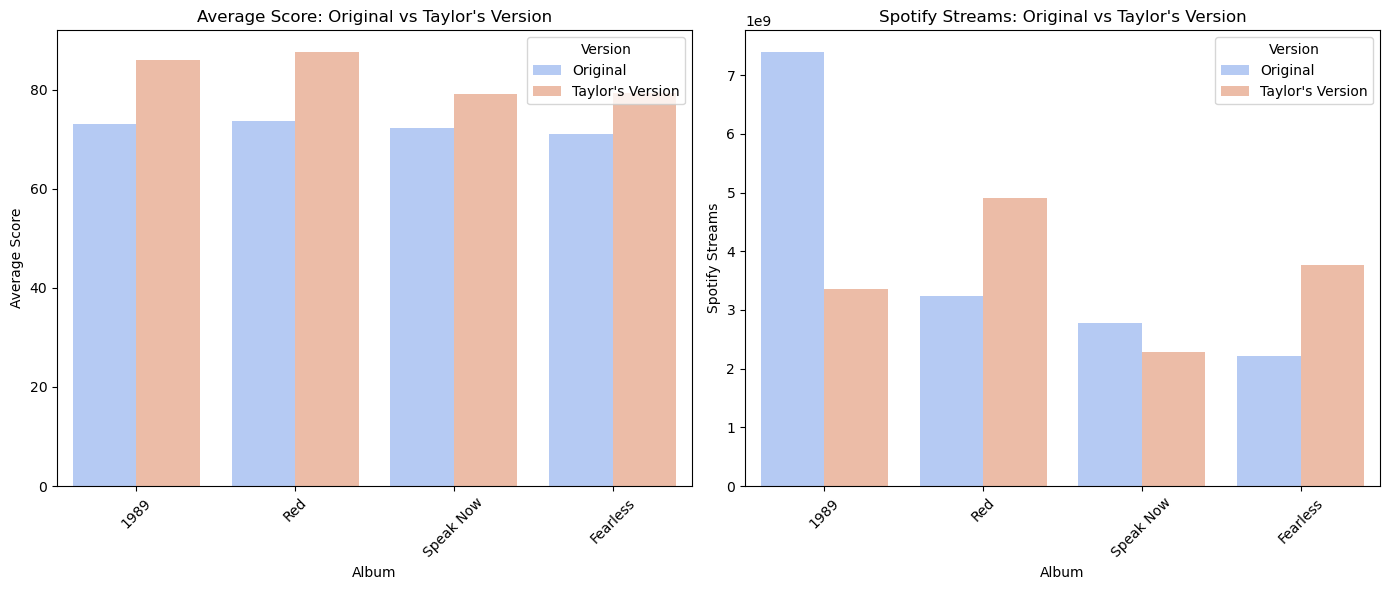

In [100]:
# Step 1: Create a column to identify re-released albums
metacritics_scores['is_taylor_version'] = metacritics_scores['album'].str.contains("(Taylor\'s Version)")

# Step 2: Separate original and re-released albums
original_albums = metacritics_scores[~metacritics_scores['is_taylor_version']].reset_index(drop=True)
taylor_versions = metacritics_scores[metacritics_scores['is_taylor_version']].reset_index(drop=True)

# Step 3: Ensure that only albums with both original and re-release are considered
# Filter out the albums without a re-release
valid_original_albums = original_albums[original_albums['album'].isin(taylor_versions['album'].str.replace(" (Taylor\'s Version)", ""))]

# Step 4: Merge original albums with their re-released versions
comparison_df = pd.merge(
    valid_original_albums,
    taylor_versions,
    left_on='album',
    right_on=taylor_versions['album'].str.replace(" (Taylor's Version)", ""),
    suffixes=('_original', '_taylor_version')
)

# Step 5: Calculate the difference in avg_score and spotify_streams
comparison_df['score_difference'] = comparison_df['avg_score_taylor_version'] - comparison_df['avg_score_original']
comparison_df['streams_difference'] = comparison_df['spotify_streams_taylor_version'] - comparison_df['spotify_streams_original']

# Step 6: Melt the dataframe to long format for easier plotting
comparison_df_melted = comparison_df.melt(id_vars='album', 
                                           value_vars=['avg_score_original', 'avg_score_taylor_version', 
                                                       'spotify_streams_original', 'spotify_streams_taylor_version'],
                                           var_name='Metric', value_name='Value')

# Step 7: Add a 'Version' column to distinguish between original and Taylor's Version
comparison_df_melted['Version'] = comparison_df_melted['Metric'].apply(
    lambda x: 'Original' if 'original' in x else 'Taylor\'s Version')

# Step 8: Create two subplots, one for avg_score and one for spotify_streams
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the average score
avg_score_data = comparison_df_melted[comparison_df_melted['Metric'].str.contains('avg_score')]
sns.barplot(x='album', y='Value', hue='Version', data=avg_score_data, ax=axes[0], palette='coolwarm')
axes[0].set_title('Average Score: Original vs Taylor\'s Version')
axes[0].set_xlabel('Album')
axes[0].set_ylabel('Average Score')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the spotify streams
streams_data = comparison_df_melted[comparison_df_melted['Metric'].str.contains('spotify_streams')]
sns.barplot(x='album', y='Value', hue='Version', data=streams_data, ax=axes[1], palette='coolwarm')
axes[1].set_title('Spotify Streams: Original vs Taylor\'s Version')
axes[1].set_xlabel('Album')
axes[1].set_ylabel('Spotify Streams')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()